# ПОСТРОЕНИЕ МОДЕЛИ ДЛЯ ПРОГНОЗИРОВАНИЯ УХОДА КЛИЕНТОВ ТЕЛЕКОМ КОМПАНИИ

## Вводные данные проекта

Оператор связи хочет научиться прогнозировать отток клиентов. Нужно спрогнозировать, уйдет клиент от оператора связи в ближайшее время или нет.

**Заказчик:** оператор связи «Ниединогоразрыва.ком».

**Основные типы услуг:** 
1. **Стационарная телефонная связь.** Возможно, подключение телефонного аппарата к нескольким линиям одновременно.
2. **Интернет.** Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*). 

**Дополнительные услуги:**

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

**Цель проекта:** построение качественной модели для максимально точного прогнозирования оттока клиентов телеком компании. 

**Дополнительная информация от заказчика:**
- целевая метрика ROC-AUC не менее 0.85;
- размер тестовой выборки 0.25;
- маркетологи посчитали: удержание текущих клиентов дешевле, чем возврат ушедших клиентов. 
- за услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Данные для анализа и построения модели:** персональные данные о некоторых клиентах, информация об их тарифах и договорах. Информация о договорах актуальна на 1 февраля 2020.
_____

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.


Признаки (`contract.csv`):
- customer_id - код клиента        
- begin_date - дата начала договора   
- end_date - дата окончания договора
- type - тип договора    
- paperless_billing - безбумажное выставление счетов
- payment_method - способ оплаты
- monthly_charges - ежемесячные траты
- total_charges - общие расходы на услуги

Признаки (`personal.csv`):
- customer_id - код клиента
- gender - пол
- senior_citizen - является ли клиент пенсионером
- partner - наличие супруга/супруги
- dependents - наличие иждивенцев
	
Признаки (`internet.csv`):
- customer_id - код клиента	
- internet_service - Интернет. Виды подключения - через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic). 
- online_security - блокировка небезопасных сайтов
- online_backup - облачное хранилище файлов для резервного копирования данных 
- device_protection - антивирус
- tech_support - выделенная линия технической поддержки
- streaming_tv - стриминговое телевидение
- streaming_movies - стриминговый каталог фильмов

Признаки (`phone.csv`):
- customer_id - код клиента
- multiple_lines - наличие подключения телефонного аппарата к нескольким линиям одновременно

## ПЛАН ПРОЕКТА И ПЕРВИЧНЫЙ АНАЛИЗ ДАННЫХ

### План проекта

1. Описать вводные данные проекта: цели, задачи, дополнительную информацию от заказчика.
2. Описать признаки в каждом из датасетов, чтобы была понятна суть каждого признака.
3. Загрузить данные, изучить общую информацию об имеющихся данных:
    - оценить количество объектов, наличие пропусков и дублей, типы данных;
    - посмотреть распределения категориальных и количественных признаков.
4. Провести исследовательский анализ данных:
    - привести данные к нужному типу;
    - объединить имеющиеся датасеты в единый датафрейм по id клиента;
    - создать целевой признак на основе признака end_date (пропуск означает, что клиент действующий, наличие даты завершения договора означает, что клиент ушел из компании);
    - создать дополнительные признаки: срок сотрудничества с клиентом (в днях), количество услуг на клиента и перечень этих услуг;
    - оценить корреляцию и, при необходимости, избавиться от мультиколлинеарности;
    - оценить баланс классов и принять решение о корректировке дисбаланса (при необходимости).
5. Подготовить данные для построения модели:
    - разделить данные на обучающую и тестовую выборки;
    - подготовить признаки, при необходимости применить кодировщики, например, OneHotEncoder;
    - выбрать целевые метрики качества согласно потребностям компании (оператора связи);
6. Построить модели:    
    - выбрать 3-4 модели ML (классификация) и осуществить подбор гиперпараметров с помощью Optuna;
    - определить лучшую модель, основываясь на метриках качества.
7. Провести финальное тестирование модели на тестовой выборке.
8. Сделать выводы по итогам проекта.    

### Первичный анализ данных

#### Импорт библиотек

Установим необходимые библиотеки:

In [1]:
# импортируем нужные библиотеки

# импорты из стандартной библиотеки
import warnings

# импорты модулей для обработки, анализа и визуализации данных
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
from phik import report
import scipy.sparse
from skimpy import clean_columns
import re
from datetime import datetime

# для подготовки признаков
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler
)    

# модели ML и подбор гиперпараметров
import optuna
from optuna.samplers import TPESampler
from optuna.visualization.matplotlib import plot_param_importances
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from catboost import *
import shap

# для оценки качества моделей
from sklearn.metrics import (
    roc_auc_score, 
    DetCurveDisplay, 
    RocCurveDisplay
) 

from sklearn.metrics import (
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report 
) 

# настройки
warnings.filterwarnings("ignore")

# константы
RANDOM_STATE = 130323
N_FOLDS = 5

#### Функции для анализа данных

In [2]:
def info_all(data):
    '''функция оценивает общую информацию о данных'''
    print('-'*50)
    print('Общая информация о данных')
    temp = data.copy() 
    list_c = data.columns
    print(temp.info())
    for col_l in list_c:
        print('-'* 25)
        print(col_l, temp[col_l].sort_values().unique())
        print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')
    print('-'*50)    
    display(data.describe()) 
    print('-'*50) 
    print('Поиск дубликатов')
    if data.duplicated().sum() == 0:
        print('Дубликаты по строкам отсутствуют')
    else:
        print('Количество дублирующихся строк:', data.duplicated().sum())
        display(data.loc[data.duplicated() == True])

In [3]:
def graph_kat(data, data_label1, data_label2=''):
    '''строит диаграммы по количеству объектов в категориальных признаках'''
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(data_label1 + ". Количество по категориям", fontsize=18)
    g = sns.countplot(data=data, x=data_label1, ax=axes[0], palette='pastel')
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    if data_label2 != '':
        axes[1].set_title(data_label2 + ". Количество по категориям", fontsize=18)
        g = sns.countplot(data=data, x=data_label2, ax=axes[1], palette='pastel')
        g.set_xticklabels(g.get_xticklabels(), rotation=90)
    plt.show()

In [4]:
def graph(data, data_label, num_bins, log_scale=False):
    '''строит гистограммы histplot и boxplot для оценки распределения количественных признаков'''
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(data_label + ". Плотность распределения", fontsize=18)
    axes[0].set_ylabel('плотность', fontsize=15)
    sns.histplot(data, bins=num_bins, ax=axes[0], color='seagreen', kde=True)
    axes[1].set_title(data_label + ". Boxplot", fontsize=18)
    sns.boxplot(data=data, x=data.index, ax=axes[1], color='mediumspringgreen')
    plt.show()

#### Загрузка данных и изучение общей информации

Загрузим для дальнейшей обработки персональные данные о клиентах, информацию об их тарифах и договорах.

##### Датасет с информацией о договорах

In [5]:
# датасет с информацией о договорах
try:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
except:
    df_contract = pd.read_csv('contract.csv')
display(df_contract.head(3))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


In [6]:
# преобразуем названия признаков в snake case
df_contract = clean_columns(df_contract)
df_contract.head(3)

8 column names have been cleaned

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


In [7]:
# изучим общую информацию
info_all(df_contract)

--------------------------------------------------
Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
-------------------------
customer_id ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
customer_id : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
begin_date ['2013-10-01' '2013-11-01' '2013-12-01' '2014-01-01' '2014-02-01'
 '201

,monthly_charges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


--------------------------------------------------
Поиск дубликатов
Дубликаты по строкам отсутствуют


Преобразуем begin_date и end_date в формат даты.

В end_date присутствуют буквенные символы 'No', вероятнее всего это отметка о том, что договор у клиента действующий на 01.02.2020 год.

Заменим 'No' на 01.02.2020, чтобы привести дату к нужному формату.

В total_charges присутствует значение ' ', посмотрим сколько таких объектов.

In [8]:
print('Количество пропущенных значений в total_charges:', sum(df_contract['total_charges'] == ' '))

Количество пропущенных значений в total_charges: 11


In [9]:
# посмотрим клиентов по которым есть пропуски
df_contract[df_contract['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Объектов немного (11 клиентов), судя по дате заключения договора это новые клиенты, пришедшие месяц назад и по ним, скорее всего, еще не отобразились общие расходы. Заменим ' ' на 0.

In [10]:
# заменим 'No' на пропуски
df_contract['end_date'] = df_contract['end_date'].replace('No', '2020-02-01')
df_contract['total_charges'] = df_contract['total_charges'].replace(' ', 0)

In [11]:
# приведем признаки к нужному формату
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'])
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'])
df_contract['total_charges'] = df_contract['total_charges'].astype('float')

In [12]:
# проверим, что типы данных теперь корректны
info_all(df_contract)

--------------------------------------------------
Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB
None
-------------------------
customer_id ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
customer_id : кол-во NaN 0 , процент NaN 0.0 %
-------------------

,monthly_charges,total_charges
count,7043.000000,7043.000000
mean,64.761692,2279.734304
std,30.090047,2266.794470
min,18.250000,0.000000
25%,35.500000,398.550000
50%,70.350000,1394.550000
75%,89.850000,3786.600000
max,118.750000,8684.800000


--------------------------------------------------
Поиск дубликатов
Дубликаты по строкам отсутствуют


**Выводы по изучению общей информации о договорах:**
- в датасете были преобразованы признаки в нужный формат - даты начала и конца договора, общие расходы;
- в столбце end_date имелись пропуски - 73.46%. Это действующие клиенты, у которых не истек срок договора, поэтому заменили пропуски на дату выгрузки 01.02.2020;
- в столбце total_charges так же имеются пропуски 0.16%, заменили их на 0, так как это новые клиенты (договоры заключены за месяц до выгрузки);
- дубликаты в данных отсутствуют.

Необходимо оценить распределение количественных признаков - monthly_charges	и total_charges. Уже сейчас видно, что в total_charges наблюдается большой разброс - достаточно большое стандартное отклонение (2266.8 при минимуме 18.8 и максимуме 8684.8), а также значительная разница между медианой (1397.5) и средним значением (2283.3).

Дату начала и окончания договора используем для расчета срока сотрудничества с клиентом. В случае действующего договора будем рассчитывать срок до 1 февраля 2020г. (дата актуальности информации о договорах).

**Оценим распределение категориальных и количественных признаков:**

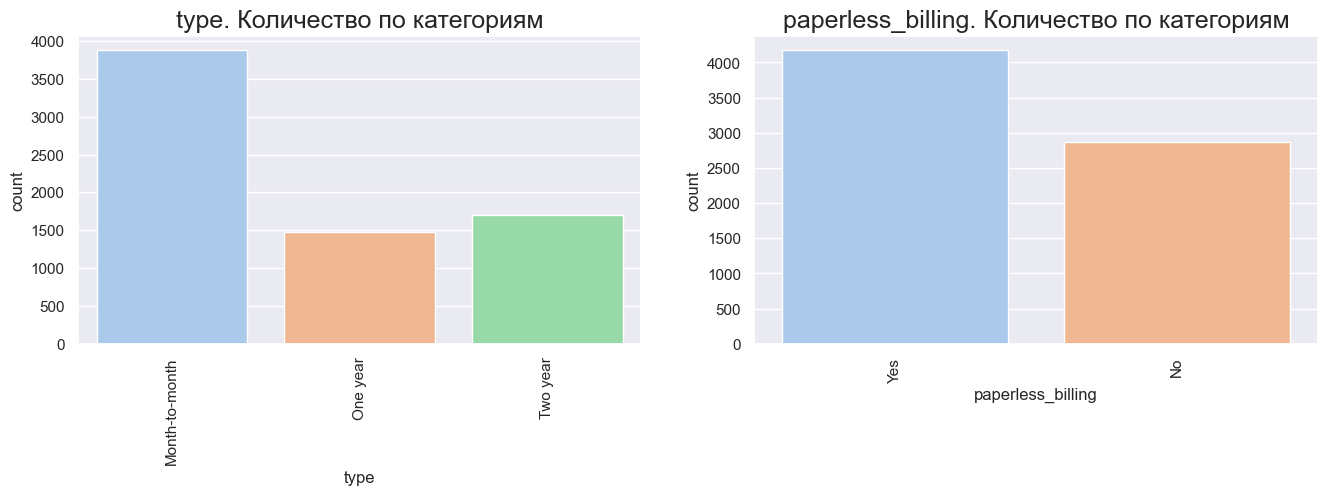

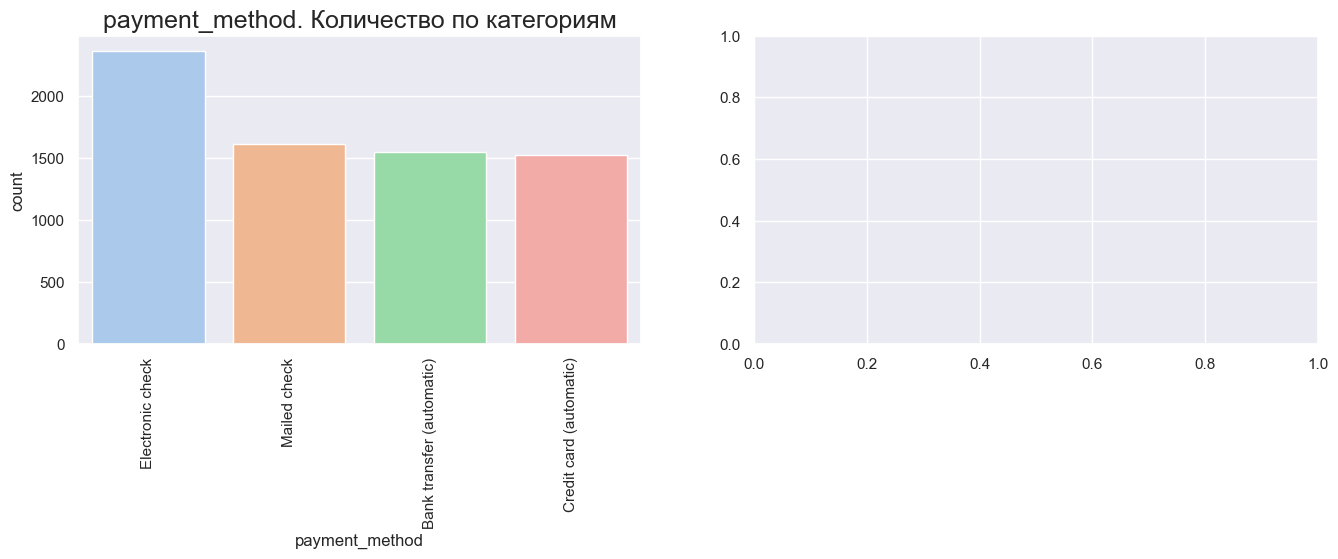

In [13]:
# построим диаграммы по количеству объектов в категориальных признаках
categories = ['type', 'paperless_billing','payment_method', '']
for i in range(len(categories)//2):
              graph_kat(df_contract, categories[2*i], categories[2*i+1])

**Категориальные признаки имеют следующее распределение:**
- примерно 50% договоров было заключено с помесячной оплатой услуг, остальные 50% распределены практически поровну на годовое и 2-х годовое обслуживание.
- безбумажным выставлением счетов пользуются чаще, тем не менее, клиентов получающих счет на бумаге, достаточно много;
- наиболее популярным способом оплаты является электронный чек, остальные способы оплаты распределены примерно в равных долях.


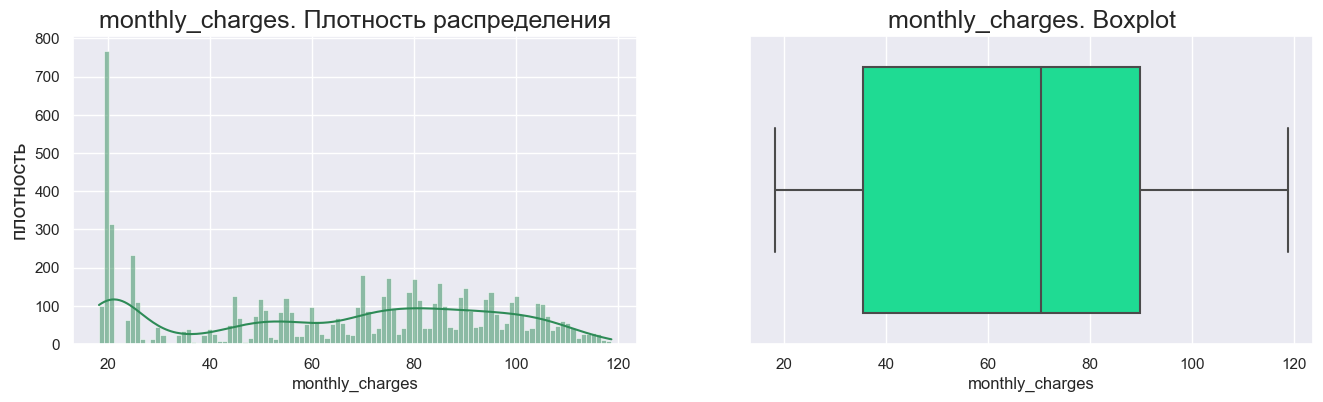

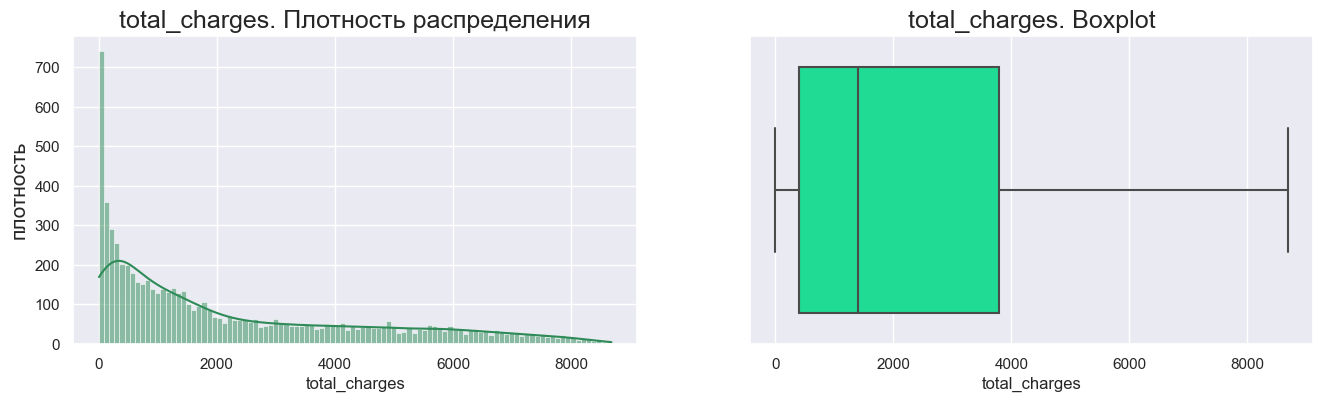

In [14]:
# построим графики гистограммы histplot и boxplot для количественных признаков 
columns_name = ['monthly_charges', 'total_charges']
for name in columns_name:
    graph(df_contract[name], name, num_bins=100)

In [15]:
print('Доля ежемесячных платежей с суммой от 20 до 25')
round(sum((df_contract['monthly_charges'] <= 25) & (df_contract['monthly_charges'] > 19))/df_contract.shape[0], 2)

Доля ежемесячных платежей с суммой от 20 до 25


0.19

In [16]:
print('Доля общих расходов с суммой от 15 до 250')
round(sum((df_contract['total_charges'] <= 250) & (df_contract['total_charges'] > 15))/df_contract.shape[0], 2)

Доля общих расходов с суммой от 15 до 250


0.19

**Количественные признаки имеют следующее распределение:**
- около 20% всех ежемесячных платежей варьируются от 20 до 25. По другим суммам платежей распределение достаточно пропорциональное с медианой около 70, наблюдаются пики в районе круглых сумм (70, 75, 80 и т.д.), что связано, скорее всего, с округлением стоимости услуг;
- около 20% общих расходов находятся в диапазоне от 15 до 250. Распределение общих расходов с левосторонней асимметрией;
- существенных аномалий и выбросов не наблюдается.

##### Датасет с персональными данными клиентов

In [17]:
# датасет с персональными данными клиентов
try:
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
except:
    df_personal = pd.read_csv('personal.csv')
display(df_personal.head(3))

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


In [18]:
# преобразуем названия признаков в snake case
df_personal = clean_columns(df_personal)
df_personal.head(3)

4 column names have been cleaned

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


In [19]:
# изучим общую информацию
info_all(df_personal)

--------------------------------------------------
Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
-------------------------
customer_id ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
customer_id : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
gender ['Female' 'Male']
gender : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
senior_citizen [0 1]
senior_citizen : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
partner ['No' 'Yes']
partner : кол-во NaN 0 , процент NaN 0.0 %
--

,senior_citizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


--------------------------------------------------
Поиск дубликатов
Дубликаты по строкам отсутствуют


**Выводы по изучению общей информации о персональных данных:**
- пропуски и дубликаты отсутствуют.

**Оценим распределение категориальных признаков:**

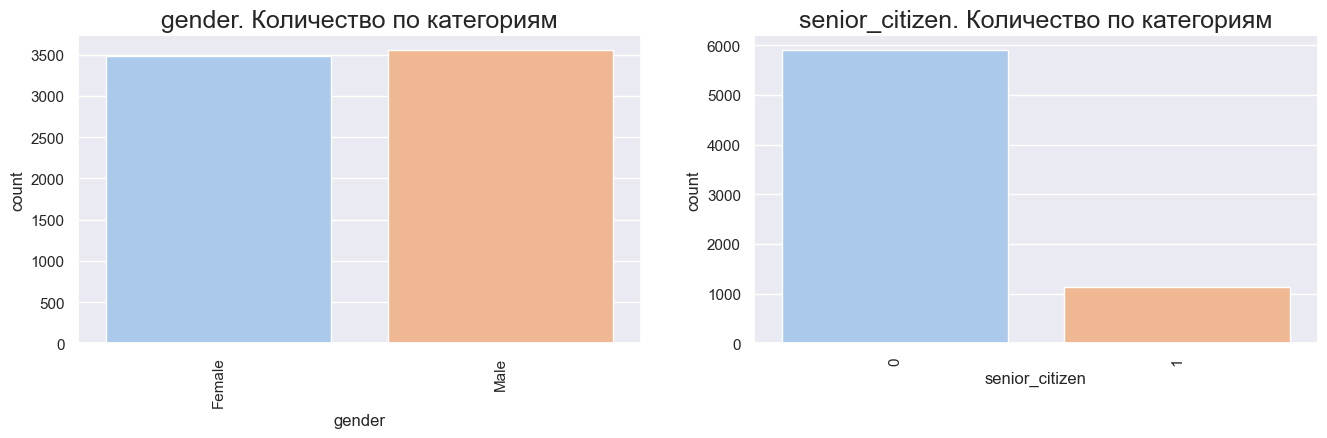

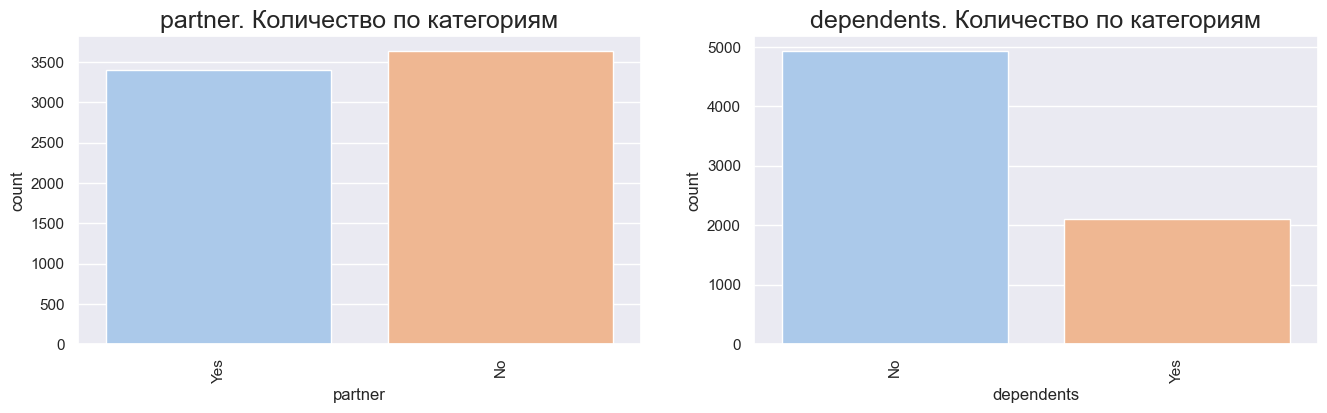

In [20]:
# построим диаграммы по количеству объектов в категориальных признаках
categories = ['gender', 'senior_citizen', 'partner', 'dependents', '']
for i in range(len(categories)//2):
              graph_kat(df_personal, categories[2*i], categories[2*i+1])

**Особенности распределения датасета по персональной информации о клиентах:**
- распределение клиентов по полу, наличию супруга/супруги равномерное.
- около 30% клиентов имеют иждивенцев;
- около 15% клиентской базы являются пенсионерами.

##### Датасет с информацией об интернет-услугах

In [21]:
# датасет с информацией об интернет-услугах
try:
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
except:
    df_internet = pd.read_csv('internet.csv')
display(df_internet.head(3))

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


In [22]:
# преобразуем названия признаков в snake case
df_internet = clean_columns(df_internet)
df_internet.head(3)

8 column names have been cleaned

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


In [23]:
# изучим общую информацию
info_all(df_internet)

--------------------------------------------------
Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
-------------------------
customer_id ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
customer_id : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
internet_service ['DSL' 'Fiber optic']
internet_service : кол-во NaN 0 , процент NaN 0.0 %
-------------

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


--------------------------------------------------
Поиск дубликатов
Дубликаты по строкам отсутствуют


**Выводы по изучению общей информации об интернет-услугах:**
- обратим внимание на тип данных признаков 'online_security', 'online_backup', 'device_protection','tech_support', 'streaming_tv', 'streaming_movies' - после объединения примем решение какой тип данных выбрать для них - булевый или категориальный;
- пропуски и дубликаты отсутствуют.

**Оценим распределение категориальных признаков:**

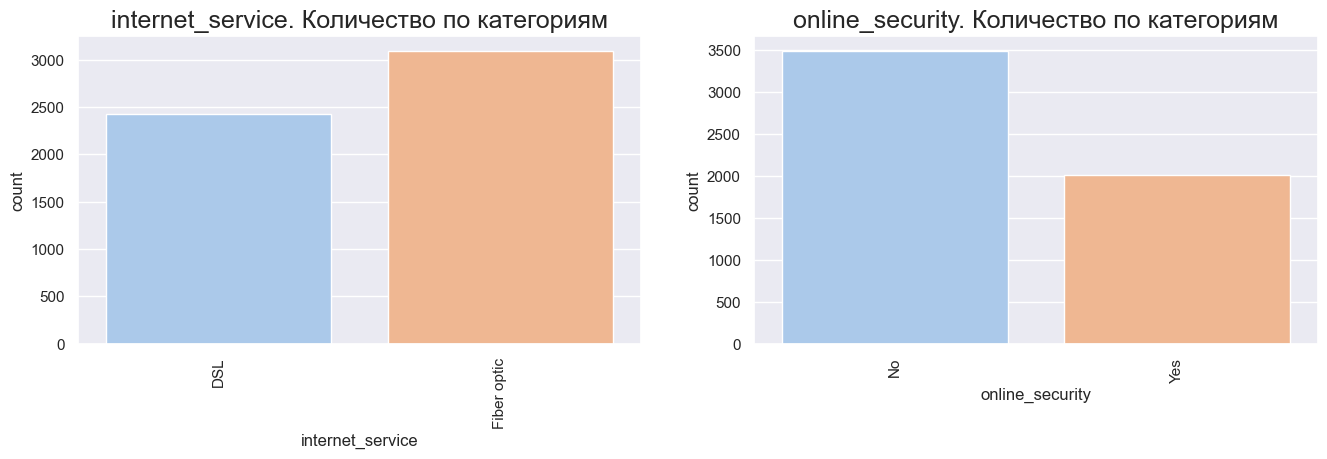

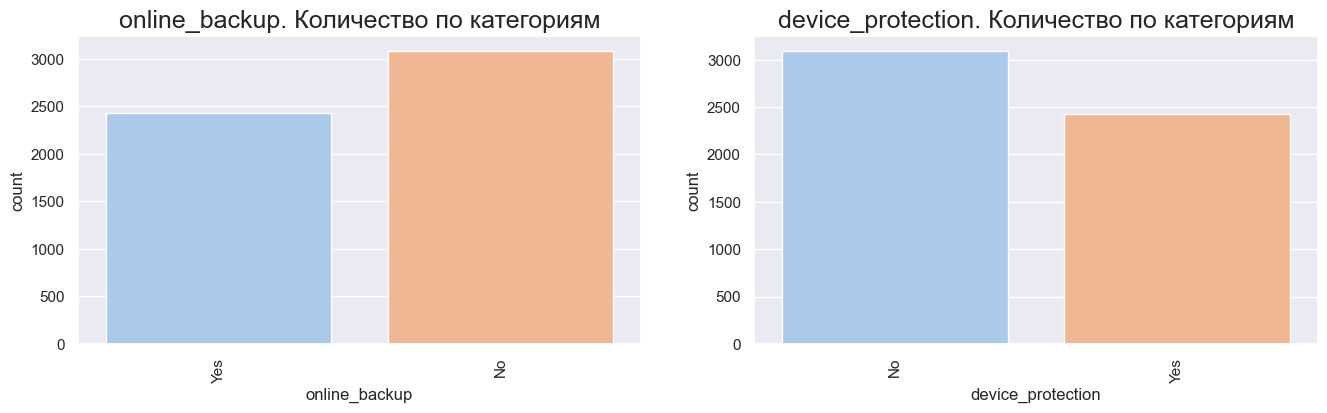

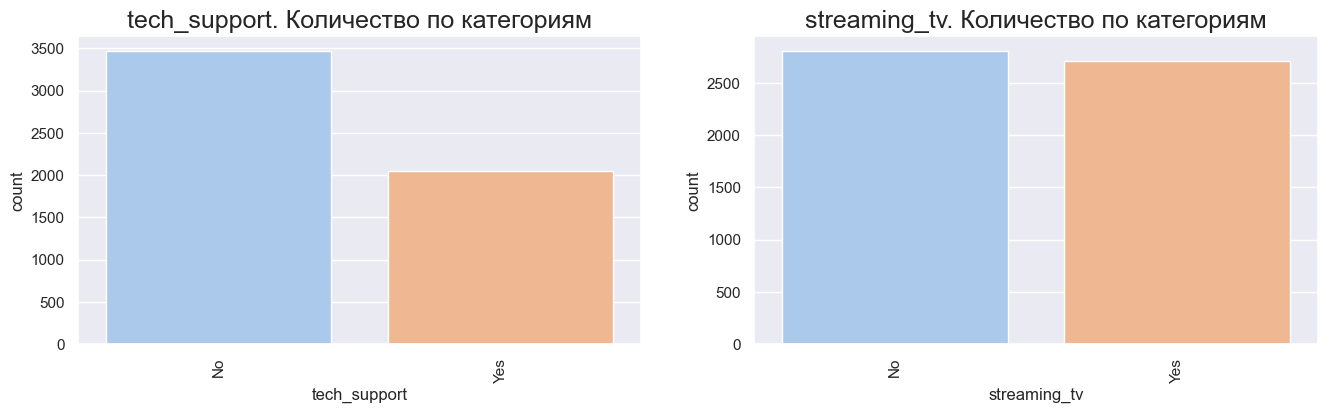

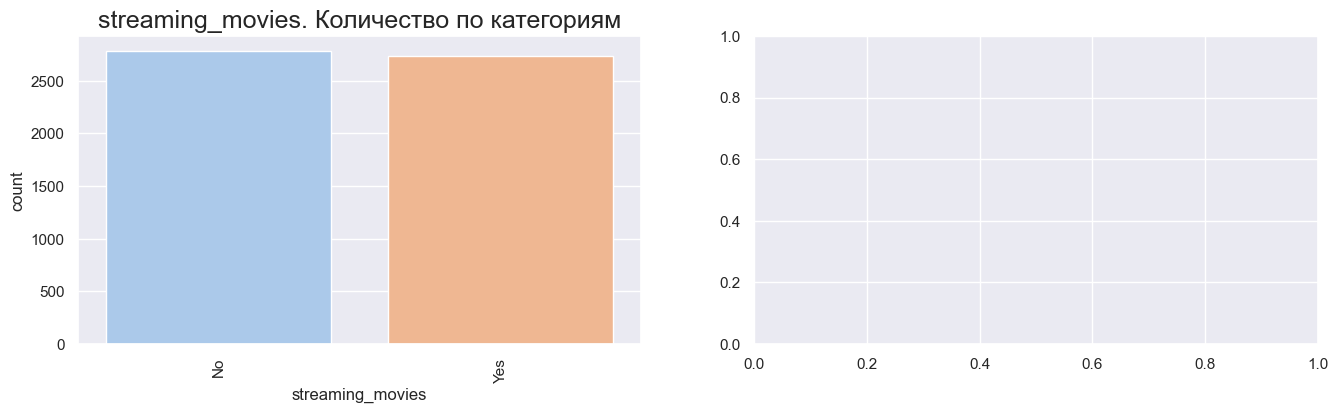

In [24]:
# построим диаграммы по количеству объектов в категориальных признаках
categories = ['internet_service', 'online_security', 'online_backup', 'device_protection','tech_support', 
              'streaming_tv', 'streaming_movies', '']
for i in range(len(categories)//2):
              graph_kat(df_internet, categories[2*i], categories[2*i+1])

**Распределение категориальных признаков имеет следующие особенности:**
- по способу подключения интернета клиенты распределены практически поровну, с небольшим преимуществом по количеству подключений с помощью оптоволоконного кабеля;
- услугами по блокировке небезопасных сайтов, облачным хранилищем, антивирусом, технической поддержкой пользовались примерно 2-2.5 тыс. клиентов из 5.5 тыс. клиентов, подключивших интернет (около 35-45% клиентов).
- наиболее популярными дополнительными услугами среди клиентов, пользующихся интернетом от оператора, являлись стриминговое телевидение и каталог фильмов. Ими пользовались более 2.5 тыс. клиентов.

##### Датасет с информацией об услугах телефонии

In [25]:
# датасет с информацией об услугах телефонии
try:
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv')
except:
    df_phone = pd.read_csv('phone.csv')
display(df_phone.head(3))

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


In [26]:
# преобразуем названия признаков в snake case
df_phone = clean_columns(df_phone)
df_phone.head(3)

2 column names have been cleaned

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


In [27]:
# изучим общую информацию
info_all(df_phone)

--------------------------------------------------
Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
-------------------------
customer_id ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-RRAMN' '9992-UJOEL'
 '9993-LHIEB']
customer_id : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
multiple_lines ['No' 'Yes']
multiple_lines : кол-во NaN 0 , процент NaN 0.0 %
--------------------------------------------------


,customer_id,multiple_lines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


--------------------------------------------------
Поиск дубликатов
Дубликаты по строкам отсутствуют


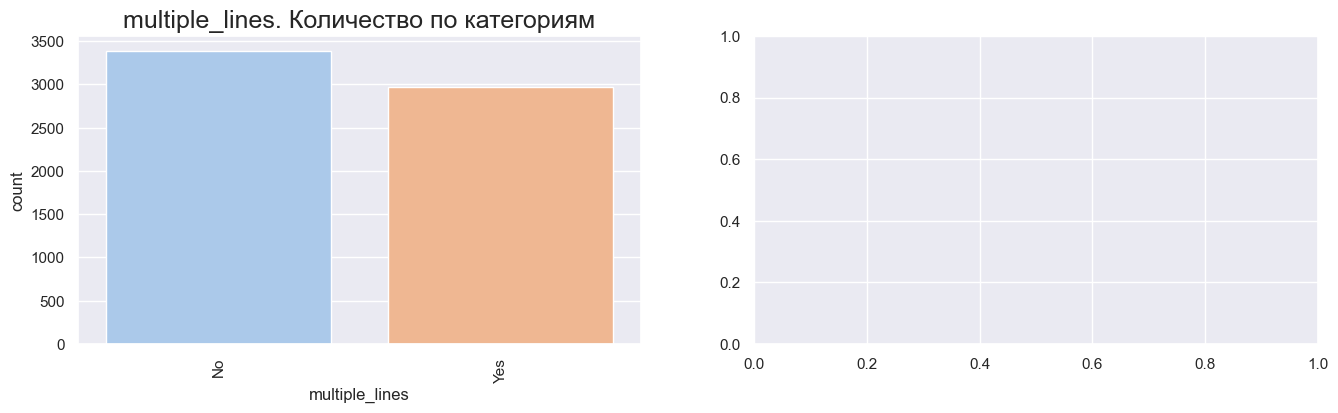

In [28]:
# построим диаграммы по количеству объектов в категориальных признаках
categories = ['multiple_lines', '']
for i in range(len(categories)//2):
              graph_kat(df_phone, categories[2*i], categories[2*i+1])

В признаке наличия подключения к нескольким линиям одновременно незначительно больше клиентов, которые не пользуются данной услугой. Около 3 тыс. клиентов пользуются данной услугой.

### Вывод по первичному анализу данных

**В ходе первичного исследовательского анализа изучена общая информация о данных в датасетах:**
- поиск дубликатов (отсутствуют);
- выявление пропусков (были обнаружены пропуски, заполненные текстовыми значениями ' ', 'No');
- распределение категориальных и количественных признаков (в целом данные не имеют аномалий и существенных выбросов);
- на первый взгляд данные корректны и пригодны для дальнейшей работы по построению модели классификации.

По некоторым признакам был изменен тип данных, например, даты.

Даты будут использоваться для конструирования дополнительных признаков - срока сотрудничества с клиентом и средних ежемесячных расходов по договору.

Более детальный анализ будет возможен после объединения датасетов в один датафрейм и выделения целевого признака из end_date (пропуск означает, что клиент действующий; наличие даты завершения договора означает, что клиент ушел из компании).

## РАЗРАБОТКА МОДЕЛИ

### Исследовательский анализ данных

#### Объединение датасетов в единый датафрейм

In [29]:
# объединим датасет с договорами и персональную информацию клиентов
df = df_contract.merge(df_personal, how='left', on='customer_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(7)
memory usage: 715.3+ KB


In [30]:
# дополняем датафрейм информацией об интернет-услугах
df = df.merge(df_internet, how='left', on='customer_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

In [31]:
df = df.merge(df_phone, how='left', on='customer_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

**Создан единый датафрейм:**

In [32]:
df.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No


В df имеются пропуски, которые возникли при объединении данных - у клиентов, которые не используют интернет, телефон или дополнительные услуги. Логично будет заполнить пропуски 'No', так как фактически клиент не пользуется этими услугами:

In [33]:
# заменяем пропуски
df = df.fillna('No')

In [34]:
# меняем тип данных у категориальных признаков на category
df = df.astype({'type': 'category', 'paperless_billing': 'category', 'payment_method': 'category', 'gender': 'category', 
                'senior_citizen': 'category', 'partner': 'category', 'dependents': 'category', 'internet_service': 'category',
                'online_security': 'category', 'online_backup': 'category', 'device_protection': 'category', 
                'tech_support': 'category', 'streaming_tv': 'category', 'streaming_movies': 'category', 
                'multiple_lines': 'category'})

In [35]:
# посмотрим общую информацию о созданном датафрейме
info_all(df)

--------------------------------------------------
Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   category      
 4   paperless_billing  7043 non-null   category      
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   category      
 9   senior_citizen     7043 non-null   category      
 10  partner            7043 non-null   category      
 11  dependents         7043 non-null   category      
 12  internet_service   7043 non-null   catego

,monthly_charges,total_charges
count,7043.000000,7043.000000
mean,64.761692,2279.734304
std,30.090047,2266.794470
min,18.250000,0.000000
25%,35.500000,398.550000
50%,70.350000,1394.550000
75%,89.850000,3786.600000
max,118.750000,8684.800000


--------------------------------------------------
Поиск дубликатов
Дубликаты по строкам отсутствуют


Создан общий датафрейм, по категориальным признакам установлен соответствующий тип данных, заменены пропуски на значение 'No' (пропуски появились при объединении таблиц и означали, что клиент не подключен к определенной услуге).

Дубликаты отсутствуют.

#### Создание целевого и дополнительных признаков

Создадим синтетических признак с **количеством дней сотрудничества:**

In [36]:
df['contract_term_days'] = round((df['end_date'] - df['begin_date']) / np.timedelta64 ( 1 , 'D')).astype(int)
df.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,contract_term_days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,DSL,No,Yes,No,No,No,No,No,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,61


Рассчитаем **количество услуг по каждому клиенту** и добавим это как дополнительный признак:

In [37]:
def count_services(row):
    '''считает количество услуг клиента'''
    count=0
    # проверяем наличие телефона без учета наличия подключения телефонного аппарата к нескольким линиям
    if row['multiple_lines'] == 'No' or row['multiple_lines'] == 'Yes':
        count+=1
    # проверяем наличие интернета с любым подключением
    if  row['internet_service'] == 'DSL' or row['internet_service'] == 'Fiber optic': 
        count+=1
    if  row['online_security'] == 'Yes':
        count+=1
    if  row['online_backup'] == 'Yes':
        count+=1
    if  row['device_protection'] == 'Yes':
        count+=1
    if  row['tech_support'] == 'Yes':
        count+=1
    if  row['streaming_tv'] == 'Yes':
        count+=1  
    if  row['streaming_movies'] == 'Yes':
        count+=1
    return count    

In [38]:
df['count_services'] = df.apply(count_services, axis=1)

In [39]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,contract_term_days,count_services
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,DSL,No,Yes,No,No,No,No,No,31,3
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,1036,4
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,61,4
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,No,1371,5
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,Fiber optic,No,No,No,No,No,No,No,61,2


Создадим **целевой признак** на основе признака end_date:

In [40]:
def create_target(end_date):
    '''отмечает 0 текущих клиентов и 1 - бывших клиентов'''
    date = pd.to_datetime('2020-02-01')
    if end_date == date:
        return 0
    else:
        return 1

In [41]:
df['target'] = df['end_date'].apply(create_target)
df.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,contract_term_days,count_services,target
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,Yes,No,No,No,No,No,31,3,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,...,Yes,No,Yes,No,No,No,No,1036,4,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,Yes,Yes,No,No,No,No,No,61,4,1


Признаки с датой начала и конца договора использовать при обучении не будем, так как будет утечка данных при обучении. 

Id клиента не несет полезной информации для обучения. Удалим эти признаки.

In [42]:
# удаляет ненужные признаки
df = df.drop(['customer_id', 'begin_date', 'end_date'], axis=1)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   type                7043 non-null   category
 1   paperless_billing   7043 non-null   category
 2   payment_method      7043 non-null   category
 3   monthly_charges     7043 non-null   float64 
 4   total_charges       7043 non-null   float64 
 5   gender              7043 non-null   category
 6   senior_citizen      7043 non-null   category
 7   partner             7043 non-null   category
 8   dependents          7043 non-null   category
 9   internet_service    7043 non-null   category
 10  online_security     7043 non-null   category
 11  online_backup       7043 non-null   category
 12  device_protection   7043 non-null   category
 13  tech_support        7043 non-null   category
 14  streaming_tv        7043 non-null   category
 15  streaming_movies    7043 non-null   ca

**Были созданы следующие признаки:**
- целевой признак с указанием действующего клиента (0) и бывшего (1);
- дополнительные синтетические признаки:
    - срок сотрудничества в днях;
    - количество услуг, используемых клиентом.

#### Оценка дисбаланса целевых классов

Количество строк в данных по классам: [5174 1869]
0    0.73463
1    0.26537
Name: target, dtype: float64


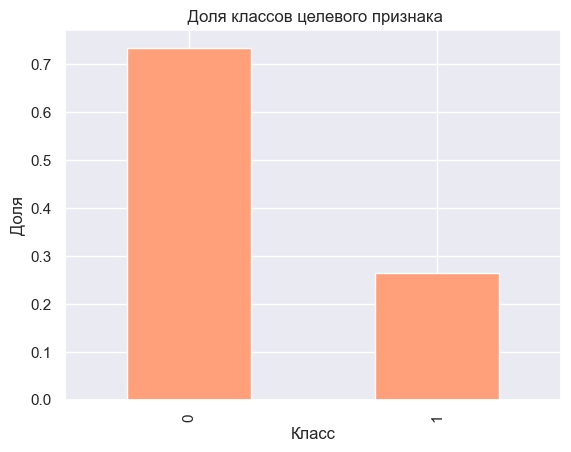

In [44]:
print(f"Количество строк в данных по классам: {np.bincount(df['target'])}")

class_balance = df['target'].value_counts(normalize = True)
print(class_balance)
class_balance.plot(kind = 'bar', color= 'lightsalmon')
plt.xlabel('Класс')
plt.ylabel('Доля')
plt.title(' Доля классов целевого признака')
plt.show()

**Целевой класс** (ушедшие клиенты) **составляет 27%** от общего количества договоров. Классы не сбалансированы. Это значит, что при обучении модели перевес будет в сторону более многочисленного класса - 0. Нашей же целью является выявление класса 1 - тех клиентов, которые потенциально могут сменить оператора связи.

При выборе целевой метрики качества нужно учитывать несбалансированность классов - приоритет следует отдать метрикам менее чувствительным к дисбалансу, например, precision и recall, которые, в отличие от accuracy, не зависят от соотношения классов, а также roc-auc.

Также можно установить балансировку классов с помощью параметра class_weight, который имеется в большинстве моделей.
Upsampling не используем, так как у нас не будет валидационной выборки (данных для обучения не много), а это значит, что при кросс-валидации возможна утечка данных.

#### Определение приоритетных метрик качества для моделей

Для того, чтобы корректно оценить значимость той или иной метрики качества модели нужно четко понимать цели компании, в частности оператора связи. В случае с оттоком действующих клиентов важно придерживаться баланса между двумя крайностями:
1. **понести сверх затраты на удержание клиентов** не планирующих менять оператора  - у модели будет перевес в пользу **recall**, соответственно ложноположительные результаты возрастут;
2. **пропустить клиента, который собирается сменить оператора** - у модели будет перевес в сторону **precision**, то есть будут отобраны только те клиенты, которые максимально точно подходят под критерии нелояльных клиентов, собирающихся уйти.

Так как маркетологи посчитали, что **удержание текущих клиентов дешевле, чем возврат ушедших клиентов,** то будем считать, что ошибки в виде ложноположительных ответов модели менее критичны, чем ложноотрицательные (клиенты были классифицированы как лояльные, но фактически уйдут из компании). В этом случае можно поработать с пороговым значением при присвоении класса.

Accuracy дает лишь общее представление о качестве модели, но не достаточно объективна при дисбалансе классов, а у нас именно такая ситуация (примерно 73% на 27%), поэтому воспользуемся следующими метриками для оценки качества модели:
- **AUC-ROC** - это целевая метрика от заказчика, размер которой должен быть не менее 0.85 на тестовой выборке; 
- **Accuracy** - рассчитаем метрику в завершении отчета на тестовой выборке, чтобы дать общее представление о качестве модели.


#### Сравнительный анализ текущих и бывших клиентов

##### Оценка категориальных признаков в зависимости от целевого класса

In [45]:
def graph_kat_2(data, data_label1, data_label2=''):
    '''строит диаграммы по количеству объектов в категориальных признаках в разрезе классов/категорий'''
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(data_label1 + ". Количество по категориям", fontsize=18)
    g = sns.countplot(data=data, x=data_label1,  hue='target', ax=axes[0], palette='pastel')
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    if data_label2 != '':
        axes[1].set_title(data_label2 + ". Количество по категориям", fontsize=18)
        g = sns.countplot(data=data, x=data_label2, hue='target', ax=axes[1], palette='pastel')
        g.set_xticklabels(g.get_xticklabels(), rotation=90)
    plt.show()

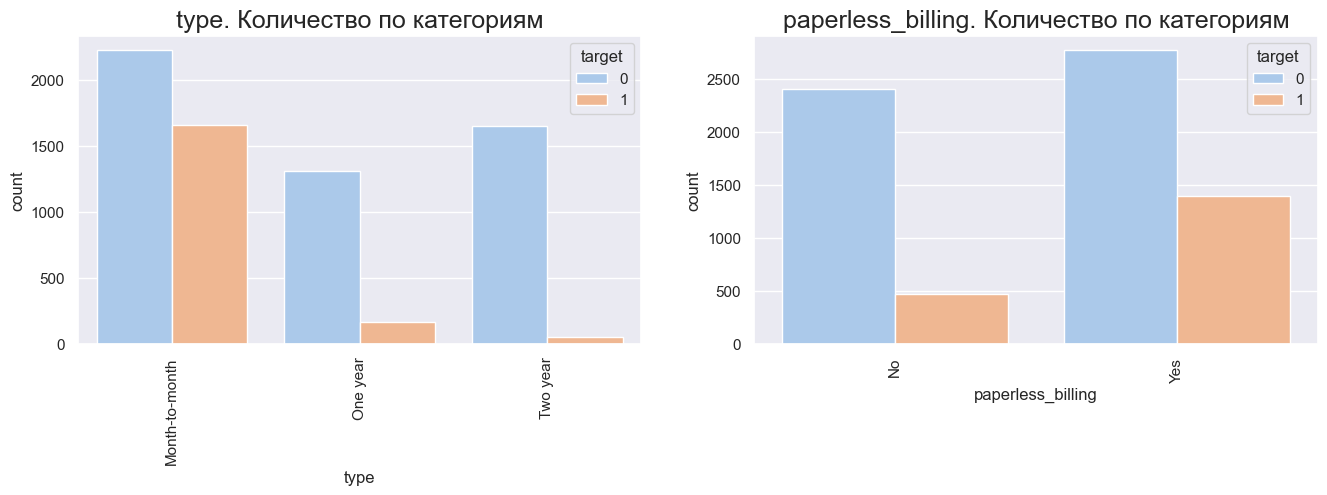

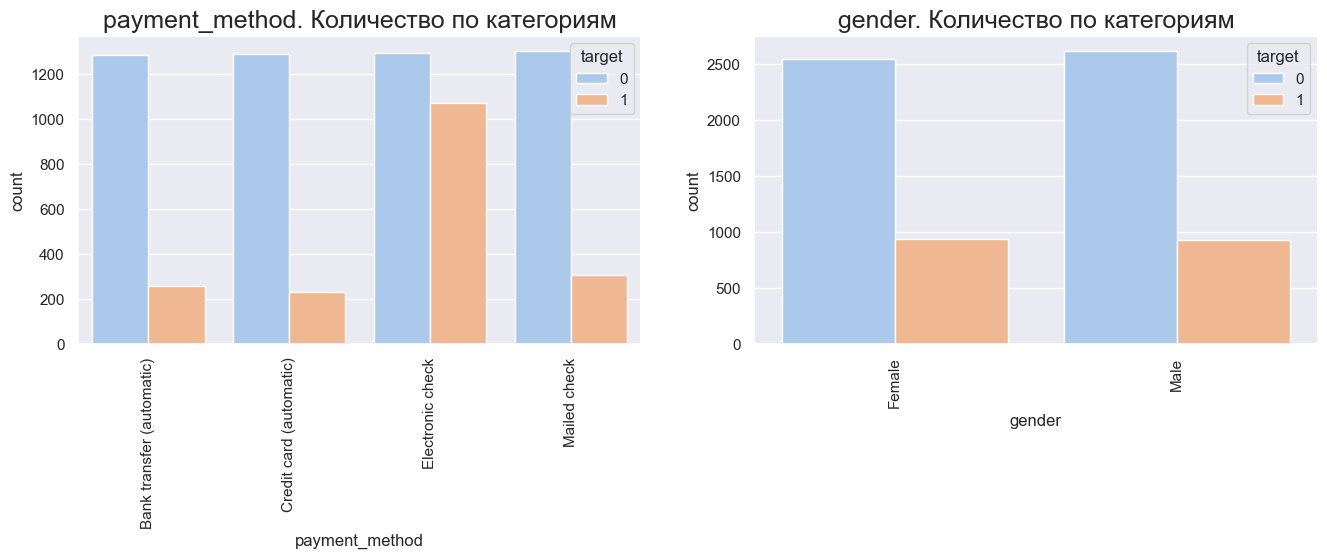

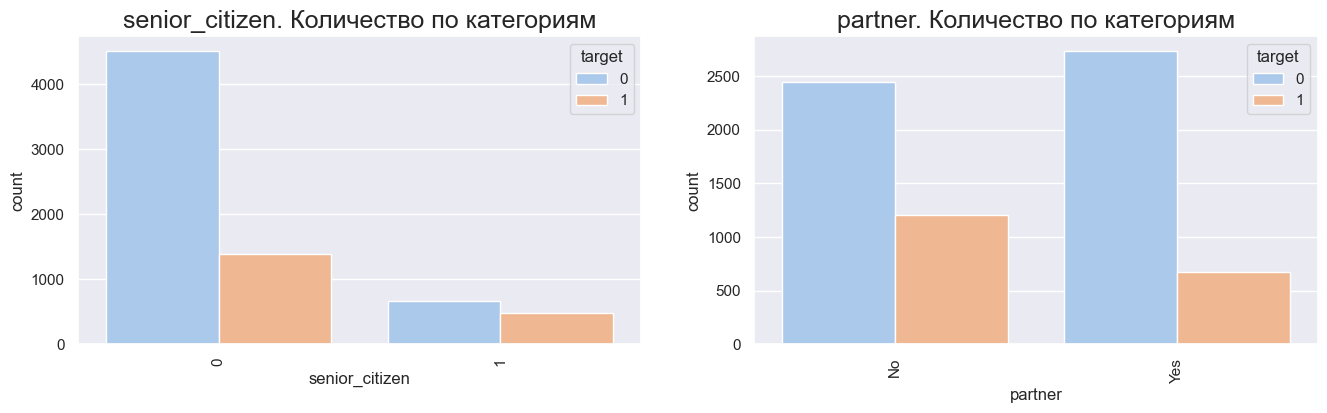

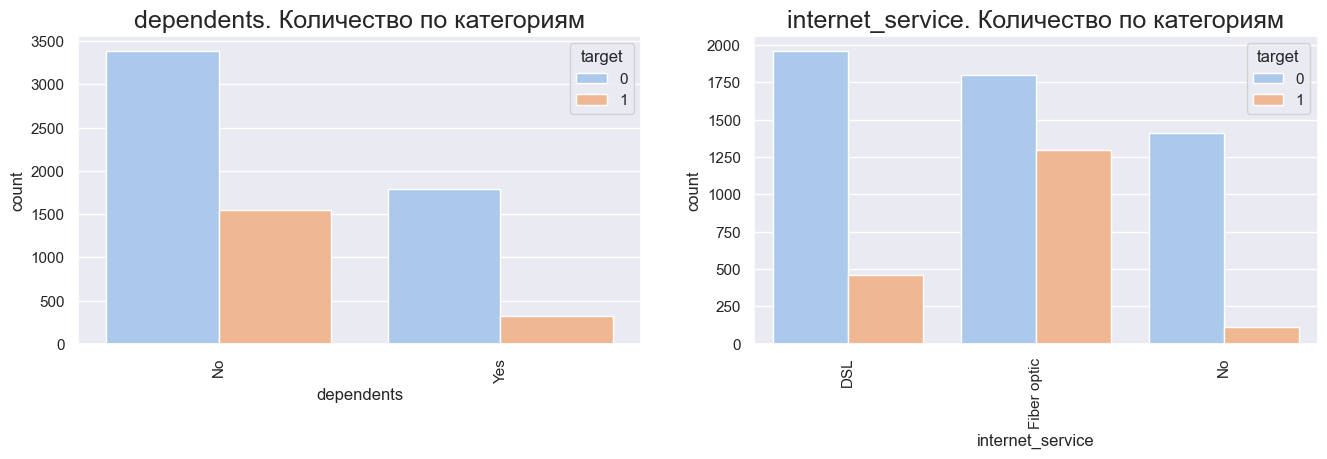

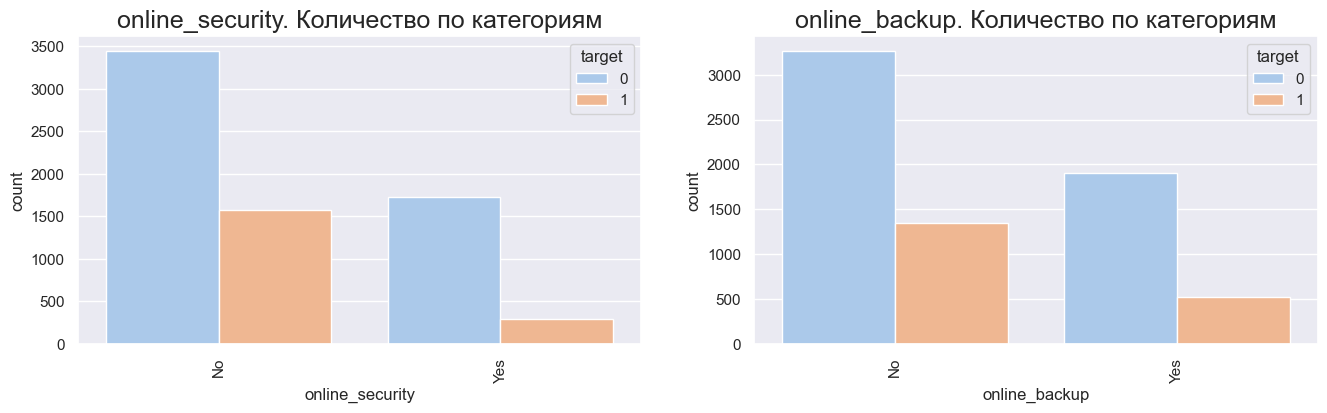

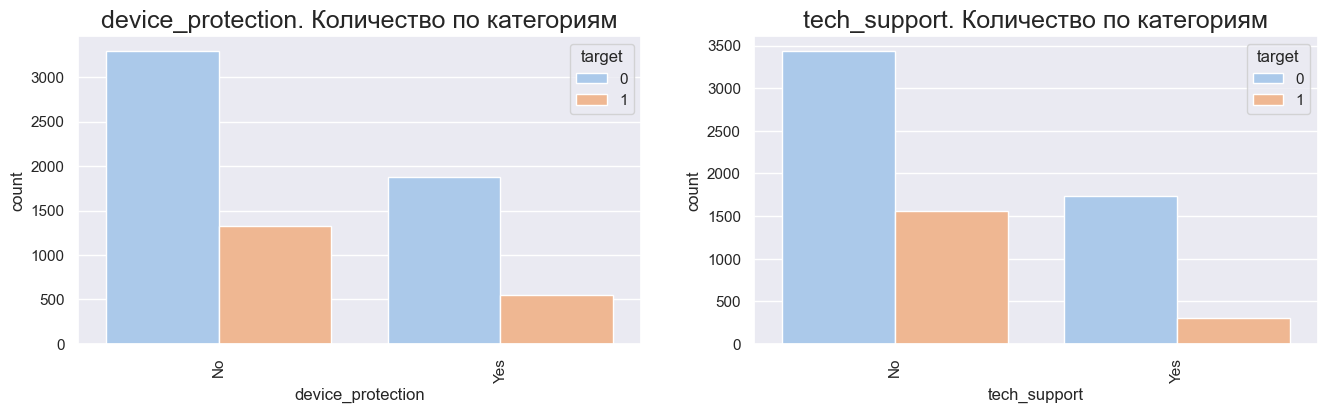

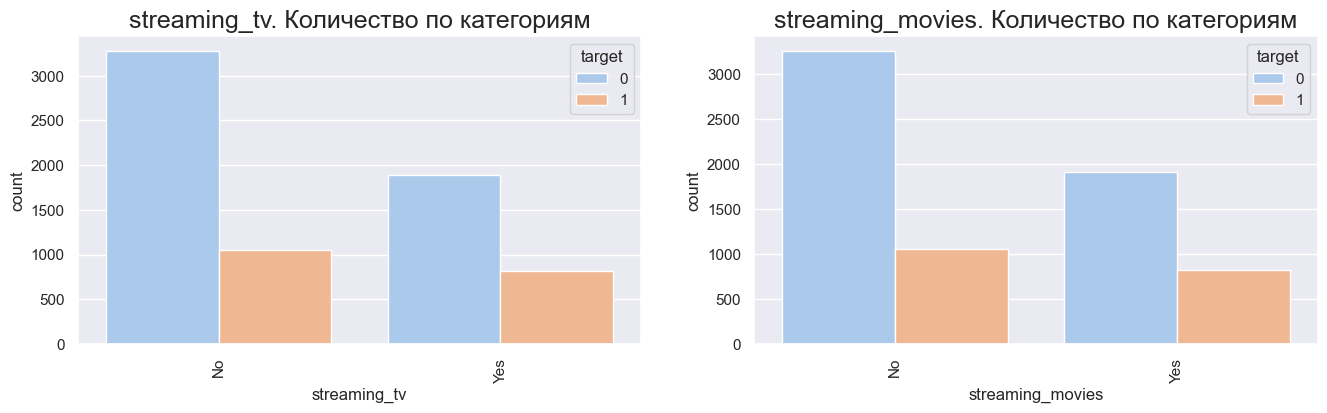

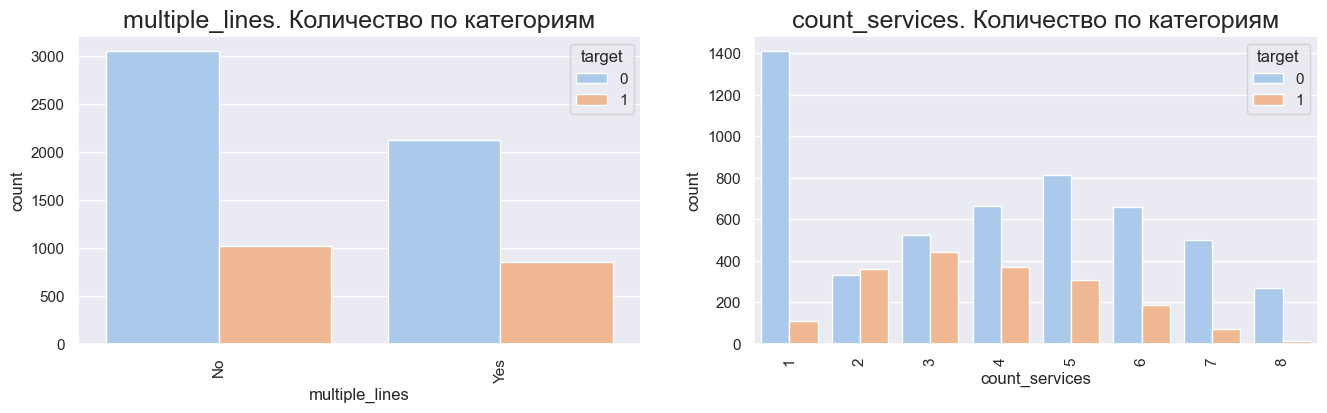

In [46]:
# построим диаграммы по количеству объектов в категориальных признаках
categories = ['type', 'paperless_billing','payment_method','gender','senior_citizen', 'partner', 'dependents', 
              'internet_service','online_security', 'online_backup', 'device_protection', 'tech_support',
              'streaming_tv', 'streaming_movies', 'multiple_lines', 'count_services', '']
for i in range(len(categories)//2):
              graph_kat_2(df, categories[2*i], categories[2*i+1])

**Оценив распределение категориальных признаков по целевым классам можно сделать следующие выводы:**

- **Типичные особенности клиентов исходя из персональной информации и срока заключения договора:**
    - в подавляющем большинстве случаев (приблизительно 90%) заключает договор ежемесячно. Действующие клиенты также чаще пользуются ежемесячным договором, однако и годовые договоры не редкость, что не удивительно для лояльных клиентов;
    - около 80% всех бывших клиентов пользовались безбумажным выставлением счетов. Лояльные же клиенты используются безбумажное выставление счетов и получение счетов на бумаге примерно с одинаковой частотой, с небольшим преимуществом безбумажных счетов;
    - более 50% использовали электронный чек как способ оплаты услуг. У действующих клиентов способы оплаты распределены равномерно, без превалирования определенного способа;
    - по половому признаку особенностей не выявлено - мужчины и женщины в равном количестве, как у лояльных, так и у ушедших от оператора клиентов;
    - пенсионеры/клиенты, имеющие иждивенцев или супруга, реже расторгают договор, чем клиенты трудоспособного возраста/без иждивенцев/без супруга;


- **Типичные особенности клиентов исходя из спектра и количества потребляемых услуг телеком-компании:**
    - большинство клиентов, расторгнувших договор и использующих услугу интернета, были подключены посредством оптоволоконного кабеля (Fiber optic);
    - клиенты, использующие многоканальный телефон, одинаково часто расторгают договор, как и те, кто не пользуется этой услугой;
    - в части использования доп. услуг:
        - чаще уходят клиенты, которые не пользуются дополнительными услугами: блокировкой небезопасных сайтов, облачным хранилищем файлов для резервного копирования данных, антивирусом, выделенной линией тех. поддержки;
        - количество нелояльные клиентов практически равнозначно среди тех, кто использует и не использует стриминговое телевидение и каталог фильмов.
    - около 70% бывших клиентов пользовались 2-мя, 3-мя или 4-мя услугами. 
    
**Далее детальнее посмотрим, какими именно услугами пользовались эти клиенты - возможно, стоит рассмотреть вариант программы лояльности для клиентов, использующих более 1-й услуги либо создать пакеты услуг по оптимальной стоимости.**

##### Анализ групп клиентов в зависимости от набора услуг

Создадим категориальный признак, который будет включать перечень всех услуг клиента:

In [47]:
def list_services (row):
    '''объединяет все услуг клиента в список'''
    services = []
    try:
        if row['multiple_lines'] == 'No' or row['multiple_lines'] == 'Yes':
            services.append('phone')
        if  row['internet_service'] == 'Fiber optic' or row['internet_service'] == 'DSL': 
            services.append('internet') 
        if  row['online_security'] == 'Yes' or row['device_protection'] == 'Yes':
            services.append('internet_security') 
        if  row['online_backup'] == 'Yes':
            services.append('online_backup') 
        if  row['tech_support'] == 'Yes':
            services.append('support')
        if  row['streaming_tv'] == 'Yes' or row['streaming_movies'] == 'Yes':
            services.append('streaming')      
        return ', '.join(services)   
    except: 
        return 'ошибка'

In [48]:
# создадим группы клиентов в зависимости от перечня их услуг
df['list_services'] = df.apply(list_services, axis=1)

In [49]:
df.head(3)

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,contract_term_days,count_services,target,list_services
0,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,...,Yes,No,No,No,No,No,31,3,0,"phone, internet, online_backup"
1,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,...,No,Yes,No,No,No,No,1036,4,0,"phone, internet, internet_security"
2,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,...,Yes,No,No,No,No,No,61,4,1,"phone, internet, internet_security, online_backup"


##### ТОП-5 групп услуг действующих клиентов

In [50]:
# посмотрим действующих клиентов
class_0_services = df[df['target'] == 0].pivot_table(index ='list_services', values= 'monthly_charges', 
                                                     aggfunc=['count', 'sum'])
class_0_services.columns = ['count', 'sum']
class_0_services['avg_sum'] = round(class_0_services['sum'] / class_0_services['count'],2)
class_0_services['share_count'] = round(class_0_services['count'] / sum(class_0_services['count']),2)
class_0_services['share_sum'] = round(class_0_services['sum'] / sum(class_0_services['sum']),2)
class_0_services = class_0_services.sort_values('sum', ascending=False)

In [51]:
# ТОП-5 перечней услуг действующих клиентов
class_0_services.head(5)

,count,sum,avg_sum,share_count,share_sum
list_services,,,,,
"phone, internet, internet_security, online_backup, support, streaming",678,62054.05,91.53,0.13,0.20
"phone, internet, internet_security, online_backup, streaming",433,38784.75,89.57,0.08,0.12
"phone, internet, internet_security, support, streaming",391,31875.80,81.52,0.08,0.10
phone,1413,29865.25,21.14,0.27,0.09
"phone, internet, internet_security, streaming",360,29242.65,81.23,0.07,0.09


**Выводы по ТОП-5 популярных перечней услуг действующих клиентов:**
- максимальный объем дохода приносит группа клиентов, **пользующихся всем спектром услуг**, средняя стоимость такого обслуживания - **91.5 денежных ед.**
- самая многочисленная группа среди действующих клиентов (1413) пользуется **только телефонией**, средняя стоимость которой составляет **21.1 денежных единиц.**

##### ТОП-5 групп услуг бывших клиентов

In [52]:
# посмотрим бывших клиентов
class_1_services = df[df['target'] == 1].pivot_table(index ='list_services', values= 'monthly_charges', 
                                                     aggfunc=['count', 'sum'])
class_1_services.columns = ['count', 'sum']
class_1_services['avg_sum'] = round(class_1_services['sum'] / class_1_services['count'],2)
class_1_services['share_count'] = round(class_1_services['count'] / sum(class_1_services['count']),2)
class_1_services['share_sum'] = round(class_1_services['sum'] / sum(class_1_services['sum']),2)
class_1_services = class_1_services.sort_values('sum', ascending=False)

In [53]:
# ТОП-5 перечней услуг с максимальным количеством бывших клиентов и потерянных объемов прибыли
class_1_services.head(5)

,count,sum,avg_sum,share_count,share_sum
list_services,,,,,
"phone, internet, streaming",356,28590.80,80.31,0.19,0.21
"phone, internet",362,22215.25,61.37,0.19,0.16
"phone, internet, internet_security, streaming",217,19033.25,87.71,0.12,0.14
"phone, internet, internet_security, online_backup, streaming",151,14588.55,96.61,0.08,0.10
"phone, internet, online_backup, streaming",114,9983.60,87.58,0.06,0.07


**Среди бывших клиентов самыми многочисленными и ресурсоемкими группами являлись:**
1. **phone, internet, streaming** (356 клиентов; потерянная сумма ежемесячного дохода **28590.80**)
2. **phone, internet** (362 клиентов;  сумма ежемесячного дохода **22215.25	**)
3. **phone, internet, internet_security, streaming** (217 клиентов;  сумма ежемесячного дохода **19033.25**)	
4. **phone, internet, internet_security, online_backup, streaming**  (151 клиентов; сумма ежемесячного дохода **14588.55**)

Клиенты с этими группами услуг составили 61% от общей суммы доходов и 58% от количества всех ушедших клиентов.

**Обратим внимание, что первые две группы (самые многочисленные и ресурсоемкие) содержат две основные услуги - телефонная связь интернет.** 

Ранее было отмечено, что нелояльные клиенты пользовались в подавляющем большинстве подключением интернета Fiber optic. Можно сравнить среднюю стоимость групп **phone, internet, streaming** и **phone, internet** по классам клиентов - скорее всего у нелояльных клиентов стоимость будет выше за счет другого способа подключения к интернету.

##### Сравнение средней стоимости популярных наборов услуг по действующим и бывшим клиентам

Посмотрим подробнее среднемесячные расходы и сроки сотрудничества по 2-м многочисленным группам бывших клиентов:
- phone, internet, streaming (356 бывших клиентов)
- phone, internet (362 бывших клиентов)

Сравним эти группы с аналогичными у действующих клиентов.

###### Стоимость набора услуг 'phone, internet, streaming' по действующим и бывшим клиентам

In [54]:
# phone, internet, streaming
# бывшие клиенты
df[(df['target'] == 1) & (df['list_services'] =='phone, internet, streaming')].describe()

,monthly_charges,total_charges,contract_term_days,count_services,target
count,356.000000,356.000000,356.000000,356.000000,356.0
mean,80.311236,1077.318118,393.148876,3.367978,1.0
std,15.887438,1267.414172,446.591735,0.482934,0.0
min,33.900000,34.700000,30.000000,3.000000,1.0
25%,79.500000,144.025000,61.000000,3.000000,1.0
50%,84.775000,584.750000,228.000000,3.000000,1.0
75%,90.362500,1478.087500,549.000000,4.000000,1.0
max,97.650000,6585.350000,2161.000000,4.000000,1.0


In [55]:
# phone, internet, streaming
# действующие клиенты
df[(df['target'] == 0) & (df['list_services'] =='phone, internet, streaming')].describe()

,monthly_charges,total_charges,contract_term_days,count_services,target
count,218.000000,218.000000,218.000000,218.000000,218.0
mean,76.510321,1695.569725,658.779817,3.399083,0.0
std,17.272223,1438.510305,515.672589,0.490837,0.0
min,33.750000,35.000000,31.000000,3.000000,0.0
25%,60.962500,543.412500,245.000000,3.000000,0.0
50%,83.100000,1341.875000,564.500000,3.000000,0.0
75%,89.350000,2447.937500,945.000000,4.000000,0.0
max,96.500000,6130.850000,2191.000000,4.000000,0.0


**Вывод:** по средней ежемесячной стоимости набор услуг "phone, internet, streaming" у действующих и бывших клиентов практически не отличается и составляет порядка 83-85 денежных ед. (медиана). 

Посмотрим среднюю стоимость интернета в разрезе подключения, чтобы подтвердить или опровергнуть предположение, что бывшие клиенты платили больше за интернет, так как способ подключения у них был Fiber optic.

###### Сравнение стоимости интернет подключения DSL  и телефонии по действующим и бывшим клиентам

Сравним оплату за интернет с подключением DSL  и телефонию у клиентов с помесячными договорами в разрезе целевых классов:

In [56]:
# phone, internet (DSL)
# бывшие клиенты
df[(df['target'] == 1) & (df['internet_service'] =='DSL') & (df['type'] =='Month-to-month') & 
   (df['list_services'] =='phone, internet')].describe()

,monthly_charges,total_charges,contract_term_days,count_services,target
count,119.000000,119.000000,119.000000,119.0,119.0
mean,39.968487,150.796639,113.462185,2.0,1.0
std,9.766116,251.457046,172.560222,0.0,0.0
min,23.450000,23.450000,30.000000,2.0,1.0
25%,25.300000,44.575000,30.000000,2.0,1.0
50%,44.950000,49.950000,31.000000,2.0,1.0
75%,45.725000,166.450000,122.000000,2.0,1.0
max,51.750000,2203.650000,1278.000000,2.0,1.0


In [57]:
# phone, internet (DSL)
# действующие клиенты
df[(df['target'] == 0) & (df['internet_service'] =='DSL') & (df['type'] =='Month-to-month') & 
  (df['list_services'] =='phone, internet')].describe()

,monthly_charges,total_charges,contract_term_days,count_services,target
count,160.000000,160.000000,160.000000,160.0,160.0
mean,40.623125,423.494687,321.531250,2.0,0.0
std,9.435971,542.522142,384.821055,0.0,0.0
min,24.150000,24.200000,31.000000,2.0,0.0
25%,25.950000,45.750000,31.000000,2.0,0.0
50%,44.750000,195.000000,168.500000,2.0,0.0
75%,45.650000,528.500000,457.000000,2.0,0.0
max,52.150000,2838.550000,1676.000000,2.0,0.0


**Вывод:** Стоимость интернета по DSL и телефонии у действующих и бывших клиентов равны, значит, тарифы со временем не менялись. Видим, что медианный срок сотрудничества в днях у бывших клиентов 31 день, то есть после месяца сотрудничества клиент уходит, либо переходит на Fiber optic из-за низкой скорости интернета. 

Оптическое волокно не подвергается помехам, поэтому связь остается стабильной при любых условиях: в грозу, снегопад или ливень. Подключение к сети через оптическое волокно позволяет пользоваться связью со скоростью от 100 Мбит/с и выше (у ADSL скорость достигает 24 Мбит/с).

###### Сравнение стоимости интернет подключения Fiber optic и телефонии по действующим и бывшим клиентам

In [58]:
# клиенты (действующие и бывшие), оформившие договор только на телефонию и интернет с оптоволоконным подключением
df[(df['internet_service'] =='Fiber optic') & (df['list_services'] =='phone, internet')].describe()

,monthly_charges,total_charges,contract_term_days,count_services,target
count,399.000000,399.000000,399.000000,399.0,399.000000
mean,72.077569,803.305388,338.215539,2.0,0.604010
std,2.528912,1042.641634,437.026566,0.0,0.489676
min,67.750000,68.500000,30.000000,2.0,0.000000
25%,69.950000,74.550000,31.000000,2.0,0.000000
50%,70.750000,308.700000,123.000000,2.0,1.000000
75%,74.750000,1132.375000,457.000000,2.0,1.000000
max,77.900000,5411.400000,2132.000000,2.0,1.000000


Теперь посмотрим в разрезе классов клиентов:

In [59]:
# phone, internet (Fiber optic)
# бывшие клиенты
df[(df['target'] == 1) & (df['internet_service'] =='Fiber optic') & (df['type'] =='Month-to-month') & 
   (df['list_services'] =='phone, internet')].describe()

,monthly_charges,total_charges,contract_term_days,count_services,target
count,240.000000,240.000000,240.000000,240.0,240.0
mean,72.150417,521.294792,218.529167,2.0,1.0
std,2.562103,747.562538,313.128991,0.0,0.0
min,67.750000,68.500000,30.000000,2.0,1.0
25%,69.950000,70.637500,31.000000,2.0,1.0
50%,70.900000,160.425000,61.000000,2.0,1.0
75%,74.862500,572.200000,242.750000,2.0,1.0
max,77.150000,3678.300000,1522.000000,2.0,1.0


In [60]:
# phone, internet (Fiber optic)
# действующие клиенты
df[(df['target'] == 0) & (df['internet_service'] =='Fiber optic') & (df['type'] =='Month-to-month') & 
   (df['list_services'] =='phone, internet')].describe()

,monthly_charges,total_charges,contract_term_days,count_services,target
count,151.000000,151.000000,151.000000,151.0,151.0
mean,71.958609,1104.851987,466.894040,2.0,0.0
std,2.478331,1132.065849,473.991338,0.0,0.0
min,68.600000,69.900000,31.000000,2.0,0.0
25%,69.950000,243.650000,92.000000,2.0,0.0
50%,70.600000,657.500000,276.000000,2.0,0.0
75%,74.475000,1564.700000,656.000000,2.0,0.0
max,77.900000,5060.850000,2041.000000,2.0,0.0


**Выводы:**

Стоимость у действующих и бывших клиентов с интернет-подключением Fiber optic не отличается, значит, ценовая политика не менялась для новых клиентов. Срок сотрудничества клиентов, которые ушли от оператора составляет 2 месяца (медиана 60 дней). 

Стоимость телефонии и интернет-подключения Fiber optic обходится дороже, чем DSL в 1.5 раза.
Скорее всего, клиенты уходят из-за высокой стоимости услуг, так как на 2-й месяц они все-таки продляют договор - это значит, что качеством подключения они, скорее всего, довольны (на DSL клиенты, ушедшие с обслуживания, в большинстве случаев не продляли договор дольше 1 месяца). 

##### Количественные признаки в разбивке по целевому классу

In [61]:
# создадим функцию для построения гистограммы histplot и boxplot
def graph_2(data, data_label, num_bins, hue=None, log_scale=False):
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(data_label + ". Плотность распределения", fontsize=18)
    axes[0].set_ylabel('плотность', fontsize=15)
    sns.histplot(data=df, x=data_label, bins=num_bins,  ax=axes[0], hue=hue, palette='pastel', kde=True)
    axes[1].set_title(data_label + ". Boxplot", fontsize=18)
    axes[1].set(xlabel=data_label, ylabel=hue)
    sns.boxplot(data=df, x=data_label, y=hue, orient="h", ax=axes[1], palette='pastel')
    plt.show()

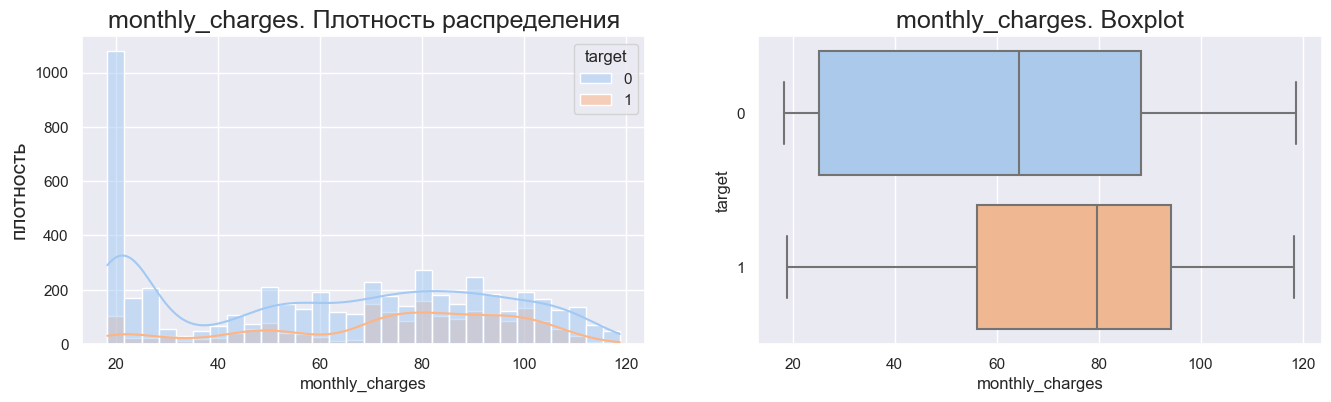

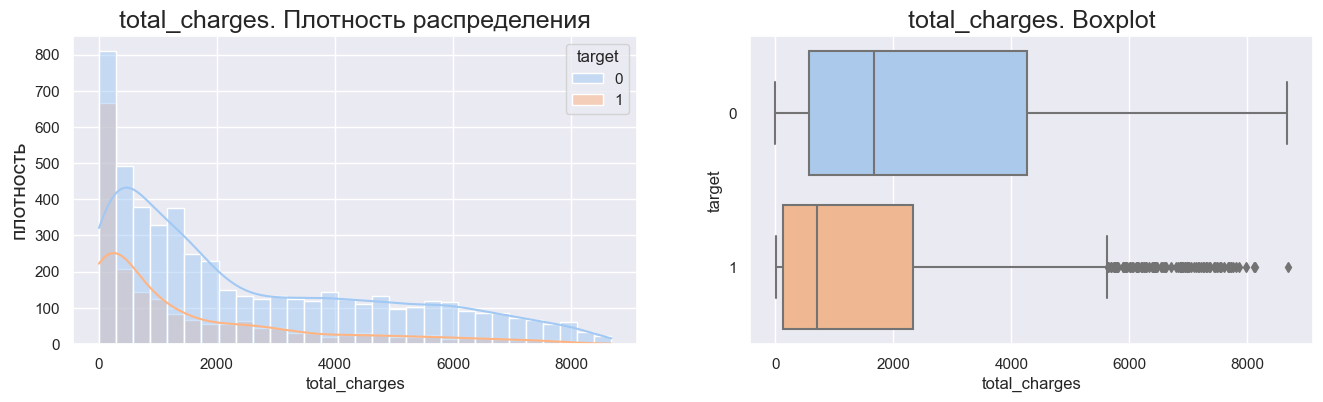

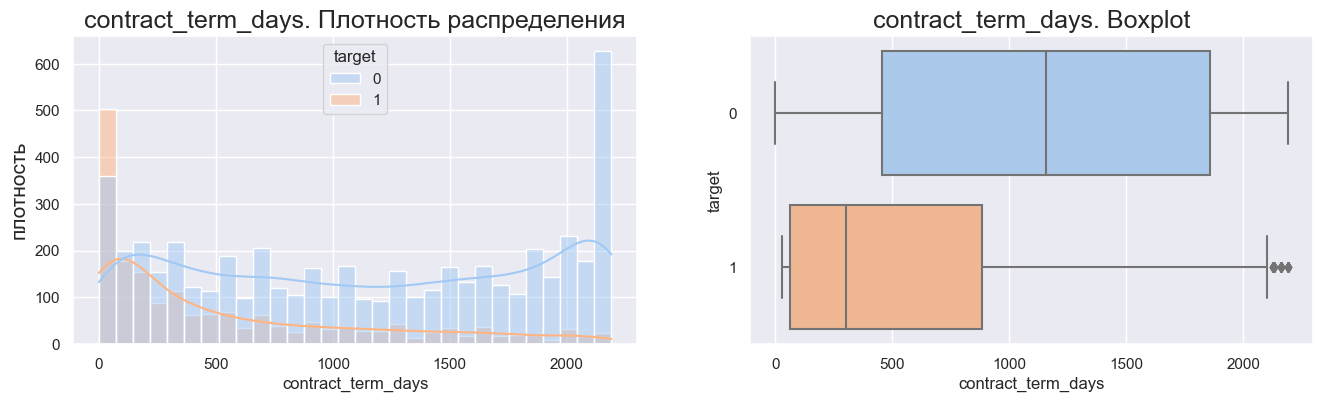

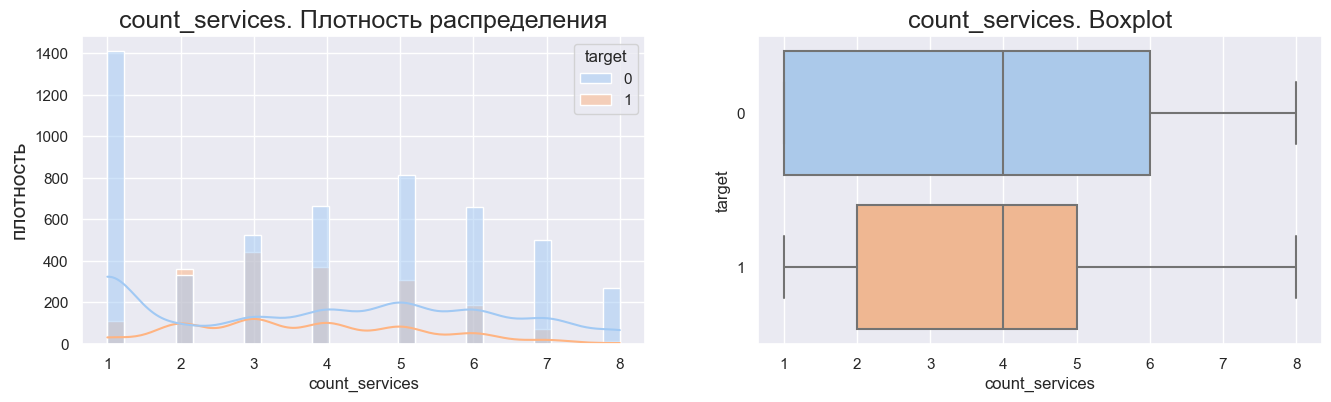

In [62]:
# построим графики
columns_name = ['monthly_charges', 'total_charges', 'contract_term_days', 'count_services']
for name in columns_name:
    graph_2(df[name], name, num_bins=30, hue='target')

**Вывод по оценке количественных признаков в разрезе классов:**
- Большое количество ежемесячных платежей в районе 20 денежный ед. наблюдается у действующих клиентов. Это клиенты только с телефонией (1413 клиентов, со среднемесячной оплатой в сумме 21.14, см. пункт 5.5.2.1  ТОП-5 групп услуг действующих клиентов).
- В целом средний чек бывших клиентов был больше, чем у действующих - 55-90  и 20-90 денежных ед. соответственно. В предыдущем пункте мы нашли предполагаемую причину - у клиентов, которые ушли, была потребность в более скоростном интернете с подключением по Fiber optic, а так как оптоволоконное интернет-подключение дороже, то клиентов, скорее всего, не устроила цена.
- Общие расходы в первый месяц соизмеримы как у действующих, так и у бывших клиентов, далее расходы у действующих значительно выше, что логично, так как они продолжали сотрудничество с оператором и расходы увеличивались. У действующих клиентов общие расходы варьируются в диапазоне от 500 до 4500 денежных ед., у бывших клиентов от 20 до 2500, при этом у ушедших клиентов наблюдаются и высокие значения затрат - 6000-8000, предположительно это те, кто заключил долгосрочный договор (на год или два).
- Типичный срок сотрудничества действующих клиентов находится в диапазоне 500-1850 дней (16-60 месяцев, то есть примерно от полутора до 5 лет). У бывших клиентов от 30 до 900 дней, то есть от месяца до 2,5 лет.
- Количество услуг у действующих клиентов чаще всего варьируется от 1 до 6, с медианой 4 услуги. У бывших от 2 услуг до 5, с медианой 4 услуги. Это еще раз подтверждает, что большую часть бывших клиентов интересовал именно скоростной интернет, а не телефония (мало тех, кто только телефонию подключил).


##### Выводы по сравнительному анализу текущих и бывших клиентов

**Типичные характеристики бывших клиентов телеком оператора:**
- **заключают договор ежемесячно**, а не на долгосрочный срок (1-2 года);
- предпочитают **безбумажное выставление счета с использованием электронного чека**, как способа оплаты;
- **реже используют дополнительные услуги**, чем лояльные клиенты;
- отдают предпочтение **скоростному интернет-подключению (Fiber optic);**
- среднее **количество услуг 2-5** (медиана 4 услуги);
- **срок сотрудничества** варьируется **от 1 месяца до 2,5 лет;**
- **средний чек** бывших клиентов больше, чем у действующих - **55-90**  и 20-90 денежных ед. соответственно. Предполагаемая причина - у клиентов, которые ушли, была потребность в более скоростном интернете с подключением по Fiber optic, а так как оптоволоконное интернет-подключение можно было приобрести только с телефонией, то и средний чек был значительно больше;
- **общие расходы** чаще всего варьируются в диапазоне **от 20 до 2500;**
- особенности по **половозрастной структуре:**
    - клиенты трудоспособного возраста, не имеющие семьи и иждивенцев менее стабильны при выборе оператора, то есть более часто расторгают договор;
    - по половому признаку особенностей не выявлено.

_____________________

**Самые многочисленные и ресурсоемкие группы по набору услуг бывших клиентов:**
1. **phone, internet, streaming** (356 клиентов; потерянная сумма ежемесячного дохода **28590.80**)
2. **phone, internet** (362 клиентов;  сумма ежемесячного дохода **22215.25	**)
3. **phone, internet, internet_security, streaming** (217 клиентов;  сумма ежемесячного дохода **19033.25**)	
4. **phone, internet, internet_security, online_backup, streaming**  (151 клиентов; сумма ежемесячного дохода **14588.55**)

Клиенты с этими группами услуг составили 61% от общей суммы доходов и 58% от количества всех ушедших клиентов.

_____________________

**Особенности потребления услуг действующими клиентами:**
- около 30% (1413 клиентов) используют только телефонную связь, без дополнительных услуг. **Средняя стоимость** такого обслуживания составляет **21.1 денежных ед.**
- примерно **12% пользуются большинством услуг** (6-ю услугами), **средняя стоимость** такого обслуживания - **91.5 денежных ед.**
- **ежемесячный средний чек 20-90 денежных ед.;**
- **общие расходы** варьируются в диапазоне **от 500 до 4500 денежных ед.;**
- типичный **срок сотрудничества** находится в диапазоне 500-1850 дней (примерно **от полутора до 5 лет**);
- **количество услуг** чаще всего варьируется **от 1 до 6**, с медианой 4 услуги.

_____________________


**Инсайты и рекомендации по итогам анализа:**

**Предполагаемая причина расторжения договоров:**
- Срок сотрудничества бывших клиентов с интернет-подключением Fiber optic составляет 2 месяца (медиана 60 дней). Стоимость интернет-подключения Fiber optic обходится дороже, чем DSL в 1.5 раза.

- **Скорее всего, клиенты уходят из-за высокой стоимости услуг** (*стоимость телефонии с интернет-подключением Fiber optic обходится дороже, чем DSL в 1.5 раза*), так как на 2-й месяц они все-таки продляют договор (*срок сотрудничества таких клиентов с интернет-подключением Fiber optic составляет 2 месяца*) - это значит, что качеством подключения они, скорее всего, довольны (на DSL клиенты, ушедшие с обслуживания, в большинстве случаев не продляли договор дольше 1 месяца.


**Рекомендованные варианты удержания клиентов:**
1. Рассмотреть создание **спец. предложения по подключению телефонии и скоростного интернета (без доп. услуг) на длительный срок по выгодной цене** - это позволит получить доход с клиента сразу и обеспечить более длительное сотрудничество с клиентом.
2. Провести **мониторинг цен конкурентов на данный способ интернет-подключения**, возможно цена выше рынка и поэтому клиенты уходят.
3. Рассмотреть **систему лояльности за долгосрочное сотрудничество**, например, бонусы или скидки клиенту через 3, 6 месяцев либо скидку на входе при заключении договора сразу на год. Это поможет продлить срок сотрудничества.

#### Корреляционный анализ данных

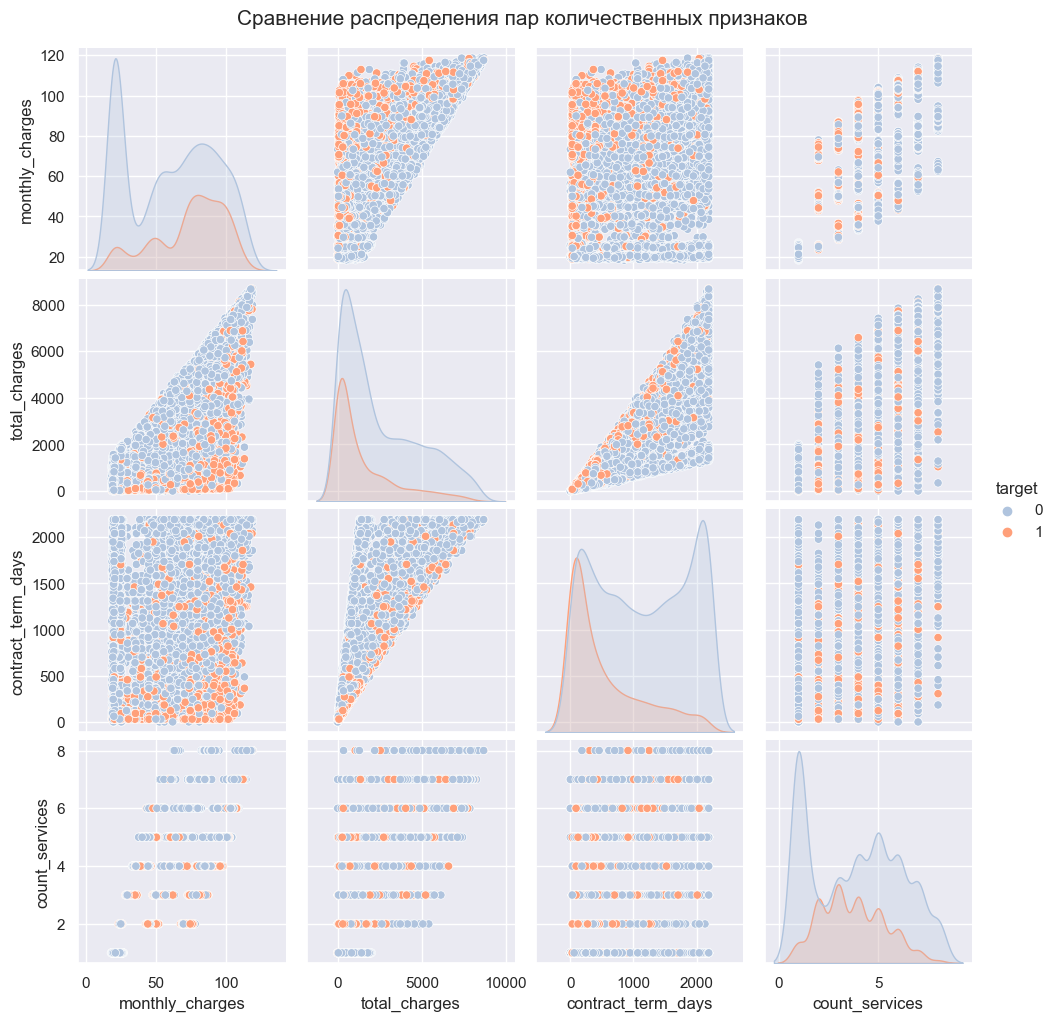

In [63]:
pp = sns.pairplot(df, hue='target',  palette=['lightsteelblue','lightsalmon'])
pp.fig.suptitle('Cравнение распределения пар количественных признаков', y=1.02, fontsize=15)
plt.show()

Из диаграммы видно:
- ежемесячные расходы коррелируются с общими расходами и количеством услуг;
- общие расходы коррелируются со сроком сотрудничества и количеством услуг.

Далее проведем более подробный корреляционный анализ, в том числе категориальных признаков с помощью phik. Это позволит уменьшить количество признаков для обучения за счет удаления признаков с мультиколлинеарностью.

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'contract_term_days', 'count_services', 'target']


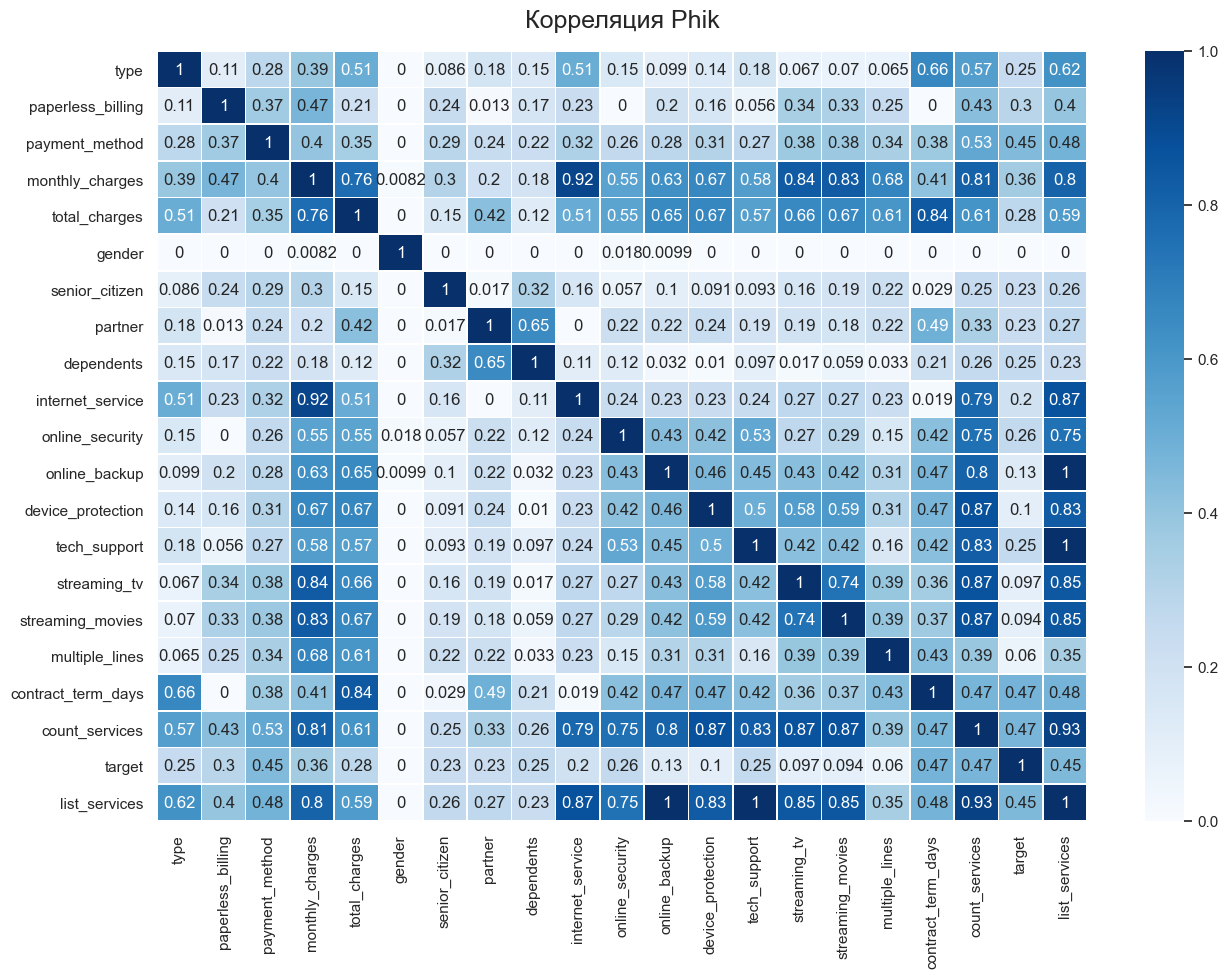

In [64]:
# посмотрим корреляцию признаков между собой
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df.phik_matrix(), annot=True, linewidths=.5, 
            ax=ax, cmap= 'Blues')
plt.title("Корреляция Phik", fontsize =18, y=1.02)
plt.show()

Итак, отберем признаки, которые коррелируются между собой более чем на 0.7 и укажем их корреляцию с целевой переменной.

Наша цель - избавиться от мультиколлинеарности, при этом не исключать признаки, которые максимально коррелируются с целевым.

**count_services:**
1. коррелируется практически со всеми дополнительными услугами, при этом с target этот признак коррелируется гораздо лучше (0.47), чем доп услуги по отдельности. Удалим следующие признаки:  'internet_service','online_security', 'online_backup', 'device_protection', 'tech_support','streaming_tv', 'streaming_movies'. 
2. Также list_services взаимосвязан с ежемесячными платежами (0.8), так как корреляция по monthly_charges с target ниже, чем с перечнем услуг, то удалим monthly_charges. 
3. list_services также удалим по причине высокой корреляции с количеством услуг.

**contract_term_days:**
1. высокая корреляция с total_charges, при этом у contract_term_days и target корреляция выше (0.47), чему у total_charges с target (0.28).

Также обратим внимание, что пол не коррелируется с другими признаками, в том числе с target. Удалим его.

Таким образом, получим следующую корреляционную матрицу из 10 признаков:

interval columns not set, guessing: ['contract_term_days', 'count_services', 'target']


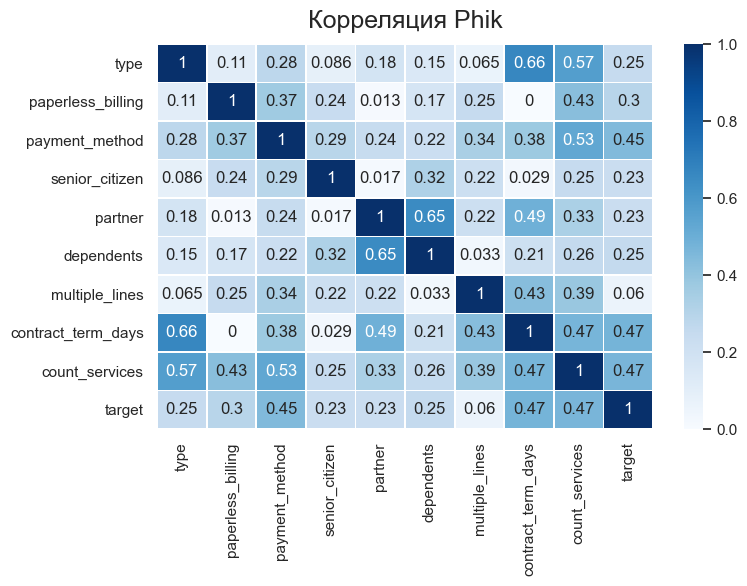

In [65]:
# посмотрим корреляцию признаков между собой
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(df[['type', 'paperless_billing',
       'payment_method', 'senior_citizen', 'partner', 'dependents', 'multiple_lines',
       'contract_term_days', 'count_services', 'target']].phik_matrix(), annot=True, linewidths=.5, ax=ax, cmap= 'Blues')
plt.title("Корреляция Phik", fontsize =18, y=1.02)
plt.show()

In [66]:
# оставляем в датафрейме выбранные признаки
df_clean = df[['type', 'paperless_billing','payment_method', 
               'senior_citizen', 'partner', 'dependents', 'multiple_lines',
               'contract_term_days', 'count_services', 'target']]
df_clean.head(3)

,type,paperless_billing,payment_method,senior_citizen,partner,dependents,multiple_lines,contract_term_days,count_services,target
0,Month-to-month,Yes,Electronic check,0,Yes,No,No,31,3,0
1,One year,No,Mailed check,0,No,No,No,1036,4,0
2,Month-to-month,Yes,Mailed check,0,No,No,No,61,4,1


**Вывод по результатам корреляционного анализа:**
- с помощью корреляционного анализа phik и попарного сравнения количественных признаков были выбраны 10 признаков для дальнейшего деления на выборки и обучения моделей.

#### Выводы по итогам исследовательского анализа данных

**В ходе исследовательского анализа были выполнены следующие этапы работ:**
- датасеты **объединены в один датафрейм**, заполнены пропуски и установлены подходящие типы данных для категориальных признаков;
- создан **целевой признак** (0 - действующий клиент, 1 - бывший клиент);
- созданы **дополнительные признаки** для анализа данных: срок сотрудничества с клиентом, количество услуг клиента, набор услуг по каждому клиенту;
- проведена **оценка дисбаланса** целевого класса (классы не сбалансированы);
- определены **приоритетные метрики качества** для модели классификации (roc-auc, recall и accuracy);
- проведен **сравнительный анализ особенностей целевых классов** (группы услуг, ТОП-5 наборов услуг по действующим и бывшим клиентам и т.д.);
- сформулированы **типичные характеристики бывших клиентов телеком оператора;**
- **выявлена предполагаемая причина расторжения договоров** - скорее всего, клиенты уходят из-за высокой стоимости услуг (стоимость телефонии с интернет-подключением Fiber optic обходится дороже, чем DSL в 1.5 раза);
- даны **рекомендации по вариантам удержания клиентов:**
    1. Рассмотреть создание **спец. предложения по подключению телефонии и скоростного интернета (без доп. услуг) на длительный срок по выгодной цене** - это позволит получить доход с клиента сразу и обеспечить более длительное сотрудничество с клиентом.
    2. Провести **мониторинг цен конкурентов на данный способ интернет-подключения**, возможно цена выше рынка и поэтому клиенты уходят.
    3. Рассмотреть **систему лояльности за долгосрочное сотрудничество**, например, бонусы или скидки клиенту через 3, 6 месяцев либо скидку на входе при заключении договора сразу на год. Это поможет продлить срок сотрудничества.

### Подготовка данных для построения модели

#### Деление данных на выборки

In [67]:
# отделяем целевой признак
features = df_clean.drop(['target'], axis=1)
target = df['target']

In [68]:
def split(features, target):
    ''' делит признаки и таргет (со стратификацией) на выборки (train, valid, test),
        проверяет пропорции в полученных выборках '''
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, 
                                                                                stratify=target, random_state=RANDOM_STATE)
    print(f'Количество строк в данных по классам: {np.bincount(target)}')
    print(f'доля: {np.bincount(target)/target.count()}')
    print(f'Количество строк в target_train по классам: {np.bincount(target_train)}') 
    print(f'доля: {np.bincount(target_train)/target_train.count()}') 
    print(f'Количество строк в target_test по классам: {np.bincount(target_test)}') 
    print(f'доля: {np.bincount(target_test)/target_test.count()}')
    return features_train, features_test, target_train, target_test

In [69]:
# делим данные на выборки
features_train, features_test, target_train, target_test = split(features, target)

Количество строк в данных по классам: [5174 1869]
доля: [0.73463013 0.26536987]
Количество строк в target_train по классам: [3880 1402]
доля: [0.73457024 0.26542976]
Количество строк в target_test по классам: [1294  467]
доля: [0.73480977 0.26519023]


In [70]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 1164 to 1103
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   type                5282 non-null   category
 1   paperless_billing   5282 non-null   category
 2   payment_method      5282 non-null   category
 3   senior_citizen      5282 non-null   category
 4   partner             5282 non-null   category
 5   dependents          5282 non-null   category
 6   multiple_lines      5282 non-null   category
 7   contract_term_days  5282 non-null   int32   
 8   count_services      5282 non-null   int64   
dtypes: category(7), int32(1), int64(1)
memory usage: 140.2 KB


Выборки сформированы пропорционально.

#### Создание трансформеров для кодирования признаков

Создадим отдельные трансформеры для логистической регрессии и случайного леса:
- для регрессии будем использовать как кодирование категориальных признаков (OneHotEncoder), так и шкалирование (StandardScaler) для количественных признаков;
- для случайного леса шкалирование не требуется, применим только OneHotEncoder.

Наименования категориальных признаков будем использовать для catboost, для lightgbm указание признаков и кодировка не нужны, необходимые признаки уже приведены к типу category.

In [71]:
#категориальные признаки для OHE
ohe_features = features_train.select_dtypes(include=['category', 'object']).columns.to_list()
ohe_features

['type',
 'paperless_billing',
 'payment_method',
 'senior_citizen',
 'partner',
 'dependents',
 'multiple_lines']

In [72]:
#численные признаки
num_features = features_train.select_dtypes(exclude=['category', 'object']).columns.to_list()
num_features

['contract_term_days', 'count_services']

In [73]:
# трансформеры
col_transformer_lr = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_features),
    (StandardScaler(), num_features),
    verbose_feature_names_out=False)

col_transformer_forest = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_features),
    verbose_feature_names_out=False)

Переходим к подбору гиперпараметров на кросс-валидации и построению моделей.

### Построение моделей и оценка их качества

Для поиска оптимальных гиперпараметров будем использовать библиотеку Optuna, которая является альтернативой GridSearchCV.

Преимущества Optuna:
- удобно формировать сетки параметров;
- возможность задавать количество 'попыток' для подбора гиперпараметров;
- скорость работы.

Будут подобраны параметры и построены следующие модели:
- CatBoostClassifier;
- LGBMClassifier;
- RandomForestClassifier;
- LogisticRegression.

В завершении будет выбрана модель с наилучшими показателями целевой метрики ROC-AUC.

#### CatBoostClassifier

In [74]:
# соберем метрики recall и accuracy на кросс-валидации для оценки моделей
list_roc = []
list_recall = []
list_accuracy = []

cv_roc = np.empty(5)
cv_recall = np.empty(5)
cv_accuracy = np.empty(5)

In [75]:
# список для результатов моделей
model_results = []

Так как optuna при нескольких итерациях обучения запоминает результаты предыдущих, то лучшие параметры удалось получит при многократном запуске подбора гиперпараметров. Для экономии времени в диапазоне параметров выбраны границы, близкие к подобранным.

In [76]:
def objective (trial, features_train, target_train):
    # границы скорректированы на основе первичных итераций обучения для сокращения времени обучения
    param_cb = {'learning_rate' : trial.suggest_float('learning_rate', 0.049, 0.04940), 
              'iterations': trial.suggest_int ('iterations', 922, 924)}
    
    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    #cv_predicts = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(features_train, target_train)):
        X_train, X_test = features_train.iloc[train_idx], features_train.iloc[test_idx]
        y_train, y_test = target_train.iloc[train_idx], target_train.iloc[test_idx]

        model_cat = CatBoostClassifier(random_state=RANDOM_STATE, class_weights=[1, 2.7], 
                                       custom_metric= 'AUC', cat_features=ohe_features, 
                                       logging_level='Silent', **param_cb)
        model_cat.fit(X_train, y_train)
        preds = model_cat.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, preds)
        cv_roc[idx] = roc_auc_score(y_test, preds)
        cv_recall[idx] = recall_score(y_test, model_cat.predict(X_test))
        cv_accuracy[idx] = accuracy_score(y_test, model_cat.predict(X_test))
    
    return np.mean(cv_roc)

In [77]:
sampler = TPESampler(seed=RANDOM_STATE)
study_cat = optuna.create_study(direction='maximize', sampler=sampler)
func = lambda trial: objective (trial, features_train, target_train)
study_cat.optimize(func, n_trials=3, show_progress_bar=True)

[I 2023-03-23 02:44:07,877] A new study created in memory with name: no-name-9a23171d-8a38-40d9-9cfa-637f6bdce8c8


  0%|          | 0/3 [00:00<?, ?it/s]

[I 2023-03-23 02:45:15,202] Trial 0 finished with value: 0.9197915661174992 and parameters: {'learning_rate': 0.04929148569444748, 'iterations': 922}. Best is trial 0 with value: 0.9197915661174992.
[I 2023-03-23 02:46:25,478] Trial 1 finished with value: 0.9212287809774986 and parameters: {'learning_rate': 0.0493502731380191, 'iterations': 923}. Best is trial 1 with value: 0.9212287809774986.
[I 2023-03-23 02:47:35,677] Trial 2 finished with value: 0.9214963109855357 and parameters: {'learning_rate': 0.04936813609097174, 'iterations': 923}. Best is trial 2 with value: 0.9214963109855357.


In [78]:
# лучшие параметры модели
study_cat.best_params

{'learning_rate': 0.04936813609097174, 'iterations': 923}

In [79]:
# модель с лучшими параметрами
model_cat = CatBoostClassifier(random_state=RANDOM_STATE, class_weights=[1, 2.7], custom_metric= 'AUC', 
                                        cat_features=ohe_features, 
                                       logging_level='Silent', **study_cat.best_params)

In [80]:
# добавляем результат в список
model_results.append(round(study_cat.best_value,2))

In [81]:
# добавим результаты метрик в общий список
list_roc.append(cv_roc)
list_recall.append(round (np.mean(cv_recall),2))
list_accuracy.append(round(np.mean(cv_accuracy),2))

#### LGBMClassifier

In [82]:
# обнуляем списки для новых результатов
cv_roc = np.empty(5)
cv_recall = np.empty(5)
cv_accuracy = np.empty(5)

In [83]:
def objective_lgbm (trial, features_train, target_train):
    param_lgbm = {'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.05),
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            "num_leaves": trial.suggest_int("num_leaves", 2, 200),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100)}
  
    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    #cv_predicts = np.empty(5)   
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(features_train, target_train)):
        X_train, X_test = features_train.iloc[train_idx], features_train.iloc[test_idx]
        y_train, y_test = target_train.iloc[train_idx], target_train.iloc[test_idx]
    
        model_lgbm = lgb.LGBMClassifier(objective="binary", metric= "auc", is_unbalance=True, 
                                        random_state=RANDOM_STATE, **param_lgbm)        
        model_lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='auc', verbose=-1)
        preds = model_lgbm.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, preds)
        cv_roc[idx] = roc_auc_score(y_test, preds)
        cv_recall[idx] = recall_score(y_test, model_lgbm.predict(X_test))
        cv_accuracy[idx] = accuracy_score(y_test, model_lgbm.predict(X_test))
    return np.mean(cv_roc)

In [84]:
sampler = TPESampler(seed=RANDOM_STATE)
study_lgbm = optuna.create_study(direction='maximize', sampler=sampler)
func = lambda trial: objective_lgbm (trial, features_train, target_train)
study_lgbm.optimize(func, n_trials=10, show_progress_bar=True)

[I 2023-03-23 02:47:35,779] A new study created in memory with name: no-name-3b9a5e2e-c337-4c43-9542-12bdfe33ddfb


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-03-23 02:47:38,497] Trial 0 finished with value: 0.8847646718906976 and parameters: {'learning_rate': 0.03914856944474848, 'n_estimators': 219, 'num_leaves': 176, 'min_child_samples': 60}. Best is trial 0 with value: 0.8847646718906976.
[I 2023-03-23 02:47:41,384] Trial 1 finished with value: 0.8948655608182484 and parameters: {'learning_rate': 0.046813609097173546, 'n_estimators': 267, 'num_leaves': 151, 'min_child_samples': 58}. Best is trial 1 with value: 0.8948655608182484.
[I 2023-03-23 02:47:43,158] Trial 2 finished with value: 0.8620443262358009 and parameters: {'learning_rate': 0.03352643510161706, 'n_estimators': 239, 'num_leaves': 9, 'min_child_samples': 73}. Best is trial 1 with value: 0.8948655608182484.
[I 2023-03-23 02:47:48,674] Trial 3 finished with value: 0.8864327577128623 and parameters: {'learning_rate': 0.03252114872753111, 'n_estimators': 319, 'num_leaves': 79, 'min_child_samples': 29}. Best is trial 1 with value: 0.8948655608182484.
[I 2023-03-23 02:47:52

In [85]:
# лучшие параметры модели
study_lgbm.best_params

{'learning_rate': 0.04012438374972537,
 'n_estimators': 468,
 'num_leaves': 188,
 'min_child_samples': 79}

In [86]:
# модель с лучшими параметрами
model_lgbm = lgb.LGBMClassifier(objective="binary", metric= "auc", is_unbalance=True, random_state=RANDOM_STATE, 
                                   **study_lgbm.best_params) 

In [87]:
# добавляем результат в список
model_results.append(round(study_lgbm.best_value,2))

In [88]:
# добавим результаты метрик в общий список
list_roc.append(cv_roc)
list_recall.append(round (np.mean(cv_recall),2))
list_accuracy.append(round(np.mean(cv_accuracy),2))

#### RandomForestClassifier

In [89]:
# обнуляем списки для новых результатов
cv_roc = np.empty(5)
cv_recall = np.empty(5)
cv_accuracy = np.empty(5)

In [90]:
def objective_forest (trial, features_train, target_train):
    param_forest = {'n_estimators': trial.suggest_int('n_estimators', 70, 1000),
                    'criterion': trial.suggest_categorical ('criterion', ['gini', 'entropy', 'log_loss']),
                    'min_samples_leaf': trial.suggest_int ('min_samples_leaf', 50,100),
                    'min_samples_split':trial.suggest_int ('min_samples_split', 5, 10)}   

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    #cv_predicts = np.empty(5)   
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(features_train, target_train)):
        X_train, X_test = features_train.iloc[train_idx], features_train.iloc[test_idx]
        y_train, y_test = target_train.iloc[train_idx], target_train.iloc[test_idx]
    
        model_forest = RandomForestClassifier(random_state=RANDOM_STATE, 
                                              class_weight='balanced', bootstrap=True, 
                                              oob_score=True, **param_forest)
        pipeline_forest = make_pipeline(col_transformer_forest, model_forest)
        pipeline_forest.fit(X_train, y_train)
        preds = pipeline_forest.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, preds)
        cv_roc[idx] = roc_auc_score(y_test, preds)
        cv_recall[idx] = recall_score(y_test, pipeline_forest.predict(X_test))
        cv_accuracy[idx] = accuracy_score(y_test, pipeline_forest.predict(X_test))
    return np.mean(cv_roc)

In [91]:
sampler = TPESampler(seed=RANDOM_STATE)
study_forest = optuna.create_study(direction='maximize', sampler=sampler)
func = lambda trial: objective_forest (trial, features_train, target_train)
study_forest.optimize(func, n_trials=3, show_progress_bar=True)

[I 2023-03-23 02:48:12,991] A new study created in memory with name: no-name-761425c3-bee5-481c-8f71-58debc6d5e2e


  0%|          | 0/3 [00:00<?, ?it/s]

[I 2023-03-23 02:48:27,891] Trial 0 finished with value: 0.7946192308565496 and parameters: {'n_estimators': 748, 'criterion': 'entropy', 'min_samples_leaf': 96, 'min_samples_split': 7}. Best is trial 0 with value: 0.7946192308565496.
[I 2023-03-23 02:48:43,242] Trial 1 finished with value: 0.7947813656082852 and parameters: {'n_estimators': 769, 'criterion': 'entropy', 'min_samples_leaf': 51, 'min_samples_split': 9}. Best is trial 1 with value: 0.7947813656082852.
[I 2023-03-23 02:48:54,044] Trial 2 finished with value: 0.794532015827888 and parameters: {'n_estimators': 594, 'criterion': 'gini', 'min_samples_leaf': 88, 'min_samples_split': 8}. Best is trial 1 with value: 0.7947813656082852.


In [92]:
# лучшие параметры модели
study_forest.best_params

{'n_estimators': 769,
 'criterion': 'entropy',
 'min_samples_leaf': 51,
 'min_samples_split': 9}

In [93]:
# модель с лучшими параметрами
model_forest = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', bootstrap=True, 
                                              oob_score=True, **study_forest.best_params) 
pipeline_forest = make_pipeline(col_transformer_forest, model_forest)    

In [94]:
# добавляем результат в список
model_results.append(round(study_forest.best_value,2))

In [95]:
# добавим результаты метрик в общий список
list_roc.append(cv_roc)
list_recall.append(round (np.mean(cv_recall),2))
list_accuracy.append(round(np.mean(cv_accuracy),2))

#### LogisticRegression

In [96]:
# обнуляем списки для новых результатов
cv_roc = np.empty(5)
cv_recall = np.empty(5)
cv_accuracy = np.empty(5)

In [97]:
def objective_lr (trial, features_train, target_train):
    param_lr = {'C' : trial.suggest_float('C', 0.1, 4),
                'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg'])}
    
    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    #cv_predicts = np.empty(5)
    #cv_recall = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(features_train, target_train)):
        X_train, X_test = features_train.iloc[train_idx], features_train.iloc[test_idx]
        y_train, y_test = target_train.iloc[train_idx], target_train.iloc[test_idx]
    
        model_lr = LogisticRegression(random_state=RANDOM_STATE, 
                                      class_weight='balanced', **param_lr)
        pipeline_lr = make_pipeline(col_transformer_lr, model_lr)
        pipeline_lr.fit(X_train, y_train)
        preds = pipeline_lr.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, preds)
        cv_roc[idx] = roc_auc_score(y_test, preds)
        cv_recall[idx] = recall_score(y_test, pipeline_lr.predict(X_test))
        cv_accuracy[idx] = accuracy_score(y_test, pipeline_lr.predict(X_test))
   
    return np.mean(cv_roc)

In [98]:
sampler = TPESampler(seed=RANDOM_STATE)
study_lr = optuna.create_study(direction='maximize', sampler=sampler)
func = lambda trial: objective_lr (trial, features_train, target_train)
study_lr.optimize(func, n_trials=5, show_progress_bar=True)

[I 2023-03-23 02:48:54,135] A new study created in memory with name: no-name-a65332a0-6470-443e-8223-fbedbebe0640


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-03-23 02:48:54,476] Trial 0 finished with value: 0.8189114003292082 and parameters: {'C': 2.941985520862977, 'solver': 'liblinear'}. Best is trial 0 with value: 0.8189114003292082.
[I 2023-03-23 02:48:54,731] Trial 1 finished with value: 0.8189184599921671 and parameters: {'C': 3.68932688697442, 'solver': 'liblinear'}. Best is trial 1 with value: 0.8189184599921671.
[I 2023-03-23 02:48:55,061] Trial 2 finished with value: 0.8189162852439946 and parameters: {'C': 2.393827422407663, 'solver': 'newton-cg'}. Best is trial 1 with value: 0.8189184599921671.
[I 2023-03-23 02:48:55,330] Trial 3 finished with value: 0.8189181648222499 and parameters: {'C': 2.295812000934283, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.8189184599921671.
[I 2023-03-23 02:48:55,596] Trial 4 finished with value: 0.8189177799055066 and parameters: {'C': 3.0167823921724866, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.8189184599921671.


In [99]:
# лучшие параметры модели
study_lr.best_params

{'C': 3.68932688697442, 'solver': 'liblinear'}

In [100]:
# модель с лучшими параметрами
model_lr = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', **study_lr.best_params) 
pipeline_lr = make_pipeline(col_transformer_lr, model_lr)

In [101]:
# добавляем результат в список
model_results.append(round(study_lr.best_value,2))

In [102]:
# добавим результаты метрик в общий список
list_roc.append(cv_roc)
list_recall.append(round (np.mean(cv_recall),2))
list_accuracy.append(round(np.mean(cv_accuracy),2))

#### Сравнение полученых метрик качества моделей и выбор лучшей

In [103]:
# объединяем результаты на кросс-валидации по метрикам ROC-AUC, Accuracy, Recall
total = []
total.append(model_results)
total.append(list_accuracy)
total.append(list_recall)

In [104]:
# создаем таблицу для сравнения целевой метрики по кросс-валидации обученных моделей
models_simile = pd.DataFrame(total, columns=['CatBoostClassifier','LGBMClassifier',
                                    'RandomForestClassifier','LogisticRegression'], 
                             index=['ROC-AUC', 'Accuracy', 'Recall'])
print('Результаты моделей на кросс-валидации:')
models_simile

Результаты моделей на кросс-валидации:


,CatBoostClassifier,LGBMClassifier,RandomForestClassifier,LogisticRegression
ROC-AUC,0.92,0.90,0.79,0.82
Accuracy,0.85,0.76,0.69,0.72
Recall,0.80,0.74,0.79,0.79


Лучшее качество модели показал CatBoostClassifier - 0.92 (ROC-AUC), 0.85 (Accuracy) и 0.80 (Recall). 

Визуализируем разброс и медианное значение результатов ROC-AUC, полученных при кросс-валидации.

In [105]:
def graf_model(results, models, name):
    '''строит боксплоты по результатам обучения моделей с метрикой ROC-AUC'''
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle(f'Результаты ROC-AUC обученных моделей по прогнозированию {name}')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(models)
    plt.show()

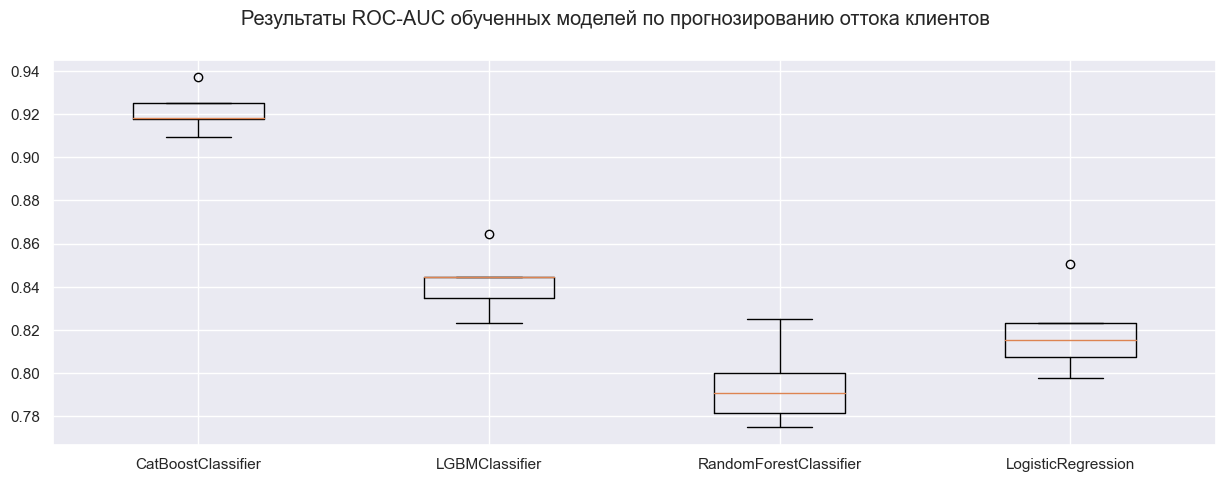

In [106]:
graf_model(list_roc, ['CatBoostClassifier','LGBMClassifier','RandomForestClassifier','LogisticRegression'], 
           'оттока клиентов')

Видим, что CatBoost показывает стабильно высокие результаты при кросс-валидации (низкое стандартное отклонение).

Используем CatBoostClassifier для тестирования.

### Тестирование выбранной модели

#### Оценка целевой метрики на тестовой выборке

In [107]:
# тест CatBoostClassifier
model_cat.fit(features_train, target_train)
preds_proba = model_cat.predict_proba(features_test)[:, 1]
prediction = model_cat.predict(features_test)
roc_auc = roc_auc_score(target_test, preds_proba)
accuracy = accuracy_score(target_test, prediction)

In [108]:
print('Метрика ROC-AUC на тестовой выборке:', round(roc_auc, 2))
print('_____________________________________________________________')
print('Метрики качества на тестовой выборке')
print(classification_report(target_test, prediction))

Метрика ROC-AUC на тестовой выборке: 0.93
_____________________________________________________________
Метрики качества на тестовой выборке
              precision    recall  f1-score   support

           0       0.94      0.87      0.90      1294
           1       0.70      0.84      0.77       467

    accuracy                           0.86      1761
   macro avg       0.82      0.86      0.83      1761
weighted avg       0.88      0.86      0.87      1761



Полученная модель удовлетворяет целевой метрике ROC-AUC не менее 0.85 - на тестовой выборке **ROC-AUC составляет 0.93**.

Дополнительные метрики:
- **Accuracy = 0.86**
- **Recall = 0.84**

Для наглядности визуализируем ROC кривую:

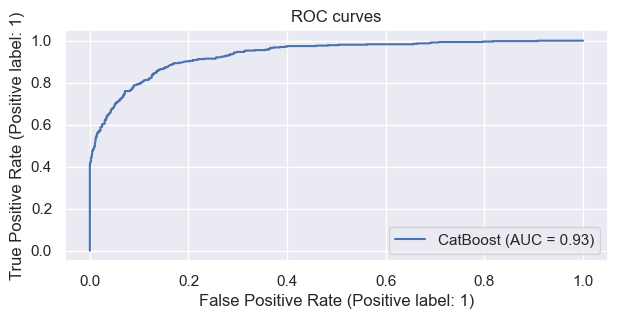

In [109]:
# строим графики Receiver Operating Characteristic (ROC) curves
fig, ax_roc = plt.subplots(figsize=(7, 3))
RocCurveDisplay.from_estimator(model_cat, features_test, target_test, ax=ax_roc, name='CatBoost')

ax_roc.set_title('ROC curves')
plt.legend()
plt.show()

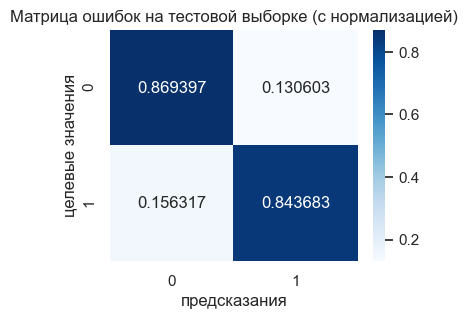

In [110]:
# построим матрицу ошибок
cm = confusion_matrix(target_test, model_cat.predict(features_test),  normalize='true')
plt.subplots( figsize=(4, 3))
sns.heatmap(cm, annot=True,  fmt='g', cmap='Blues')

plt.title('Матрица ошибок на тестовой выборке (с нормализацией)', fontsize=12 )
plt.xlabel('предсказания')
plt.ylabel('целевые значения')
plt.show()

При оценке матрицы ошибок видим, что ошибок при определении 1 класса больше, чем при определении 0, а нам важно минимизировать ложноотрицательные ошибки (0.16) (клиенты были классифицированы как лояльные, но фактически уйдут из компании), так как по данным маркетологов удержание текущих клиентов дешевле, чем возврат ушедших клиентов. Поэтому важно повысить полноту определения целевого класса (1).

Для этого подберем новое пороговое значение. Визуализируем измение порога присвоения класса и подберем оптимальный порог с учетом метрики accuracy и полноты.

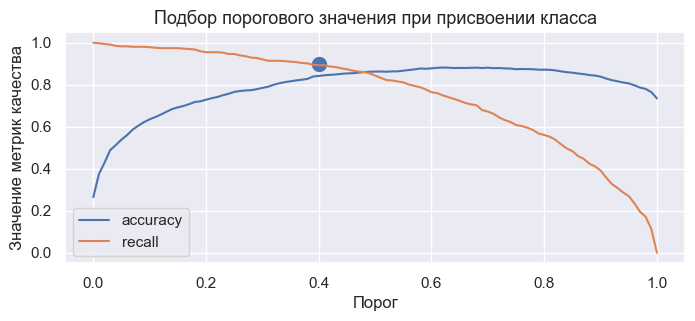

In [111]:
# рассчитываем метрики качества в зависимости от размера порога
accuracy = []
recall = []
for threshold in np.arange(0, 1.01, 0.01):
    predict = preds_proba > threshold
    accuracy.append([float('{:.2f}'.format(threshold)),float('{:.4f}'.format(accuracy_score(target_test, predict)))])
    recall.append([float('{:.2f}'.format(threshold)),float('{:.4f}'.format(recall_score(target_test, predict)))])

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(np.array(accuracy)[:,0], np.array(accuracy)[:,1], label = 'accuracy')
ax.plot(np.array(recall)[:,0], np.array(recall)[:,1], label = 'recall')
ax.scatter(0.4, 0.90, c='b', lw = 5) 
ax.legend()
plt.xlabel('Порог')
plt.ylabel('Значение метрик качества')
plt.title('Подбор порогового значения при присвоении класса', fontsize=13 )

plt.show()

Подобрали такой порог, чтобы accuracy не слишком снизилась, а **recall** максимально увеличилась - получим 0.4. Применим новый порог:

In [112]:
# применим выбранный порог
prediction = np.where(preds_proba >= 0.4, 1, 0)
roc_auc = roc_auc_score(target_test, preds_proba)
accuracy = accuracy_score(target_test, prediction)

In [113]:
# посмотрим отчет по метрикам качества с учетом изменения порога
print('Метрика ROC-AUC на тестовой выборке:', round(roc_auc, 2))
print('_____________________________________________________________')
print('Метрики качества на тестовой выборке')
print(classification_report(target_test, prediction))

Метрика ROC-AUC на тестовой выборке: 0.93
_____________________________________________________________
Метрики качества на тестовой выборке
              precision    recall  f1-score   support

           0       0.96      0.82      0.88      1294
           1       0.65      0.89      0.75       467

    accuracy                           0.84      1761
   macro avg       0.80      0.86      0.82      1761
weighted avg       0.87      0.84      0.85      1761



Теперь видим, что полнота определения 1 класса увеличилась на 0.05, accuracy снизилась на 0.02, так как 0 класс больше. 
На метрику ROC-AUC изменение порога никак не повлияло, так как она рассчитана на вероятностях.

Теперь посмотрим на сколько уменьшились ложноотрицательные ошибки: 

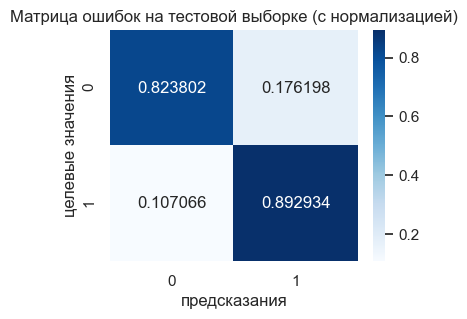

In [114]:
# построим матрицу ошибок
cm = confusion_matrix(target_test, prediction,  normalize='true')
plt.subplots( figsize=(4, 3))
sns.heatmap(cm, annot=True,  fmt='g', cmap='Blues')

plt.title('Матрица ошибок на тестовой выборке (с нормализацией)', fontsize=12 )
plt.xlabel('предсказания')
plt.ylabel('целевые значения')
plt.show()

Ошибка в определении 1 класса снизилась на 0.05. Полнота определения 1-го класса уменьшилась на 0.05. 

Таким образом, порог определения класса можно корректировать в зависимости от бизнесс-целей.

#### Оценка важности признаков при определении классов

Построим график важности признаков с помощью shap:

In [115]:
explainer = shap.TreeExplainer(model_cat)
shap_values = explainer.shap_values(features_test)

In [116]:
shap_values = explainer.shap_values(Pool(features_train, target_train, cat_features=ohe_features))

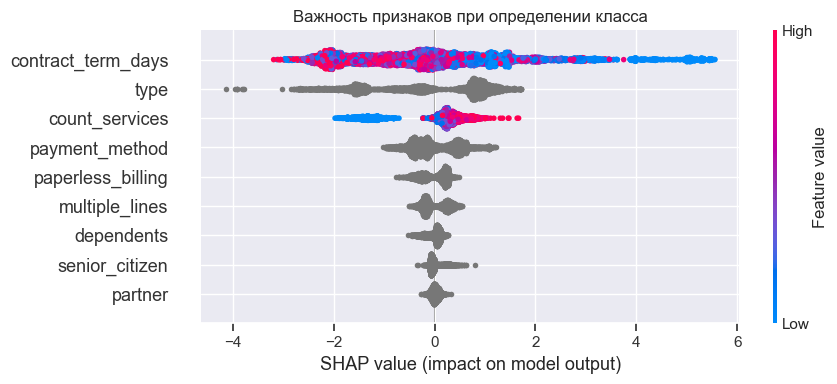

In [117]:
plt.title('Важность признаков при определении класса')
shap.summary_plot(shap_values, features_train, plot_size=(9,4))

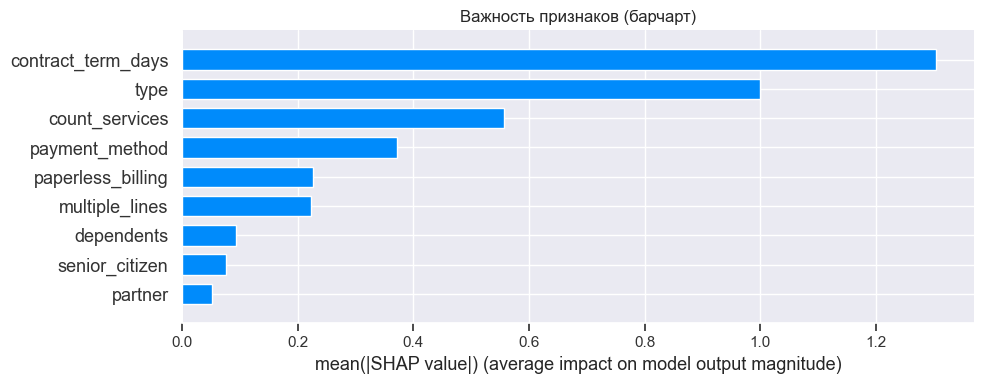

In [118]:
plt.title('Важность признаков (барчарт)')
shap.summary_plot(shap_values, features_train, plot_type="bar", plot_size=(10,4))
plt.show()

Интерпретация ТОП-3 признаков, влияющих на предсказание модели:
1. **Срок сотрудничества**. Самым весомым признаком является срок сотрудничества - чем больше срок сотрудничества, тем ниже вероятность ухода клиента. И наоборот - бывшие клиенты, в большинстве своем, сотрудичали с оператором короткое время (ранее мы выяснили, что примерный срок сотрудничества составлял 30-60 дней).
2. **Тип договора по сроку**. У лояльных клиентов срок договора более длительный.
3. **Количество услуг**. Мало склонны к уходу клиенты с минимальным количеством услуг - ранее мы выяснили, что это клиенты использующие только телефонную связь. Тем не менее при максимальном количестве услуг у клиентам, вероятность, что он уйдет ниже.


## ОТЧЕТ ПО ИТОГАМ ПРОЕКТА

### Аннотация

Удержание клиентов является одним из приоритетных направлений бизнеса. Как правило, сохранение клиенткой базы экономически выгоднее, чем привлечение новых клиентов.

**Отток клиентов** — одна из наиболее важных метрик, которые оцениваются бизнесом. Этот показатель показывает реальную картину потери клиентов и, соответственно, последующую потерю доходов компании. 

Прогнозирование оттока клиентов с помощью интеллектуального анализа данных и методов машинного обучение позволит нивелировать долю нелояльных клиентов и снизить отток клиенской базы. 

**Целью данного проекта** является построение качественной модели для максимально точного прогнозирования оттока клиентов оператора связи «Ниединогоразрыва.ком».

Настоящий отчет содержит этапы и результаты работ по реализации задачи классификации методами классического машинного обучения (градиентный бустинг, случайный лес и логистическая регрессия).

### Введение

**В данном проекте были реализованы следующие этапы работ:**
1. Загружены и подготовлены к анализу данные;
2. Проведен разведочный анализ данных с формированием портрета нелояльного клиента;
3. Данные подготовлены к построению моделей:
    - разделены на обучающую и тестовую выборки;
    - подготовлены признаки с помощью кодировщиков (OneHotEncoder и StandardScaler);
    - выбраны целевые метрики качества согласно потребностям компании (оператора связи);
4. Построены модели:    
    - выбраны 4 моделей ML (градиентные бустинги, случайный лес и логистическая регрессия) и осуществлен подбор гиперпараметров с помощью Optuna;
    - определена и протестирована лучшая модель.
5. Сделаны выводы по итогам проекта. 

**Общие блоки работ** отражены на рисунке:

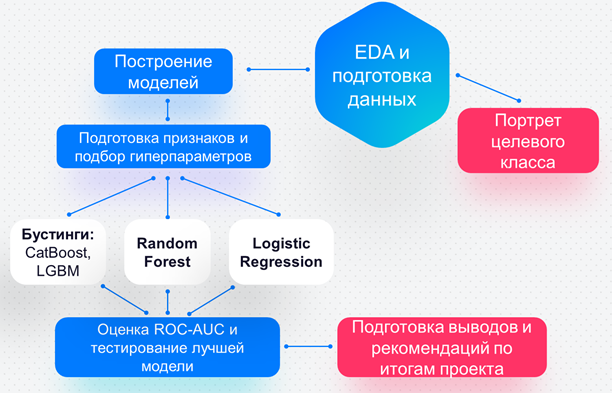

Проект был реализован **в двух ключевых направлениях:**
1. `построение модели машинного обучения`, способной прогнозировать уход клиента исходя из его потребительского поведения и персональных признаков;
2. `формирование портрета нелояльного клиента` и выявление предполагаемых причин расторжения договоров.

В рамках текущего отчета отражены результаты, полученные по данным направлениям, а также сформированы рекомендации по удержанию клиентов, склонных к оттоку.

### Данные для анализа и создание дополнительных признаков

**Данными для анализа и построения модели** являлись персональные данные о некоторых клиентах, информация об их тарифах и договорах. Выгрузка данных осуществлялась 1 февраля 2020, именно на эту дату информация являлась актуальной.

В данных присутствовала информация о следующих услугах:
- **Основные типы услуг:** 
    1. **Стационарная телефонная связь.** Возможно, подключение телефонного аппарата к нескольким линиям одновременно.
    2. **Интернет.** Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*). 
- **Дополнительные услуги:**
    - Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
    - Выделенная линия технической поддержки (*TechSupport*);
    - Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
    - Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

**Исходная информация была представлена в 4-х датасетах:**
- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

После объединения исходных 4-х датасетов (по столбцу `customerID`) была проведена предварительная подготовка данных к построению модели:
- заполнение пропусков на 'No' (пропуски появились при объединении таблиц и означали, что клиент не подключен к определенной услуге), 
- приведение значений признаков к нужному типу данных.

По итогу был получен **единый датафрейм**, состоящий **из 7043 объектов** и следующих признаков:

|Признак | Тип объектов| Описание признака|
| --------- | -------- | ---------|
|customer_id |object |   код клиента  |
|begin_date |datetime|  дата начала договора |
|end_date| datetime|дата окончания договора|
|type| category  |  тип договора     |
|paperless_billing| category | безбумажное выставление счетов|       
|payment_method | category |способ оплаты |       
|monthly_charges |float |ежемесячные траты |       
|total_charges| float| общие расходы на услуги |     
|gender | category | пол|       
|senior_citizen|  category |  является ли клиент пенсионером   |   
|partner | category | наличие супруга/супруги|        
|dependents  |  category   | наличие иждивенцев|     
|internet_service| category | Интернет (через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic))|  
|online_security | category |  блокировка небезопасных сайтов    |
|online_backup |category |   облачное хранилище файлов для резервного копирования данных   | 
|device_protection| category |антивирус |       
|tech_support|  category |  выделенная линия технической поддержки |    
|streaming_tv | category | стриминговое телевидение|       
|streaming_movies|category|стриминговый каталог фильмов  |      
|multiple_lines| category |  наличие подключения телефонного аппарата к нескольким линиям одновременно   |

**Созданы следующие признаки:**
- целевой признак с указанием действующего клиента (0) и бывшего (1). Количество объектов по классам: 0 - 5174 объекта (73%), 1 - 1869 объектов (27%).
- дополнительные синтетические признаки:
    - срок сотрудничества в днях на основе признаков begin_date и end_date;
    - количество услуг, используемых клиентом.

**Удалены следующие признаки:**
- begin_date и end_date с последующим их удалением, так как возможна утечка данных и исскуственное завышение качества модели;
- customer_id, так как не несет полезной информации.

### Разведочный анализ данных

**В ходе разведочного анализа:**

- выявлен `дисбаланс классов - 1:3` в пользу класса 0 (действующие клиенты). Для его устранения использовались стандартные параметры обученных моделей, например, class_weight. 
- определены `приоритетные метрики качества` для модели классификации (`roc-auc, recall и accuracy`);
- проведен `сравнительный анализ особенностей целевых классов` (группы услуг, ТОП-5 наборов услуг по действующим и бывшим клиентам и т.д.) и сформулированы `типичные характеристики бывших клиентов телеком оператора:`
    - `заключают договор ежемесячно`, а не на долгосрочный срок (1-2 года);
    - предпочитают `безбумажное выставление счета с использованием электронного чека`, как способа оплаты;
    - `реже используют дополнительные услуги`, чем лояльные клиенты;
    - отдают предпочтение `скоростному интернет-подключению (Fiber optic);`
    - среднее `количество услуг 2-5` (медиана 4 услуги);
    - `срок сотрудничества` варьируется `от 1 месяца до 2,5 лет;`
    - `средний чек` бывших клиентов больше, чем у действующих - `55-90` и 20-90 денежных ед. соответственно. Предполагаемая причина - у клиентов, которые ушли, была потребность в более скоростном интернете с подключением по Fiber optic, а так как оптоволоконное интернет-подключение можно было приобрести только с телефонией, то и средний чек был значительно больше;
    - `общие расходы` чаще всего варьируются в диапазоне `от 20 до 2500;`
    - особенности по `половозрастной структуре:`
        - клиенты трудоспособного возраста, не имеющие семьи и иждивенцев менее стабильны при выборе оператора, то есть более часто расторгают договор;
        - по половому признаку особенностей не выявлено.
- `выявлена предполагаемая причина расторжения договоров` - скорее всего, клиенты уходят из-за высокой стоимости услуг (стоимость телефонии с интернет-подключением Fiber optic обходится дороже, чем DSL в 1.5 раза);
- даны `рекомендации по вариантам удержания клиентов:`
    1. Рассмотреть создание `спец. предложения по подключению телефонии и скоростного интернета (без доп. услуг) на длительный срок по выгодной цене` - это позволит получить доход с клиента сразу и обеспечить более длительное сотрудничество с клиентом.
    2. Провести `мониторинг цен конкурентов на данный способ интернет-подключения`, возможно цена выше рынка и поэтому клиенты уходят.
    3. Рассмотреть `систему лояльности за долгосрочное сотрудничество`, например, бонусы или скидки клиенту через 3, 6 месяцев либо скидку на входе при заключении договора сразу на год. Это поможет продлить срок сотрудничества.

### Выбор и подготовка признаков для построения модели

С целью выбора признаков для обучения моделей ML проведен `корреляционный анализ с помощью phik`, который показал взаимосвязь не только количественных, но и качественных признаков.

Это позволило уменьшить количество признаков для обучения за счет удаления признаков с мультиколлинеарностью. 
Созданные нами признаки `'count_services'` и `'contract_term_days'` обладают достаточной корреляцией с целевым признаком 'target' (0.47) и позволяют исключить ряд признаков:
- 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'monthly_charges', 'list_services' (мультиколлинеарность с созданным входе анализа признаком 'count_services');
- 'total_charges' (высокая корреляция с 'contract_term_days');
- 'gender' - практически не коррелируется с прочими признаками, в том числе с целевым, а значит, не будет влиять на результат предсказания.

Таким образом, получим следующую корреляционную матрицу из 10 признаков:

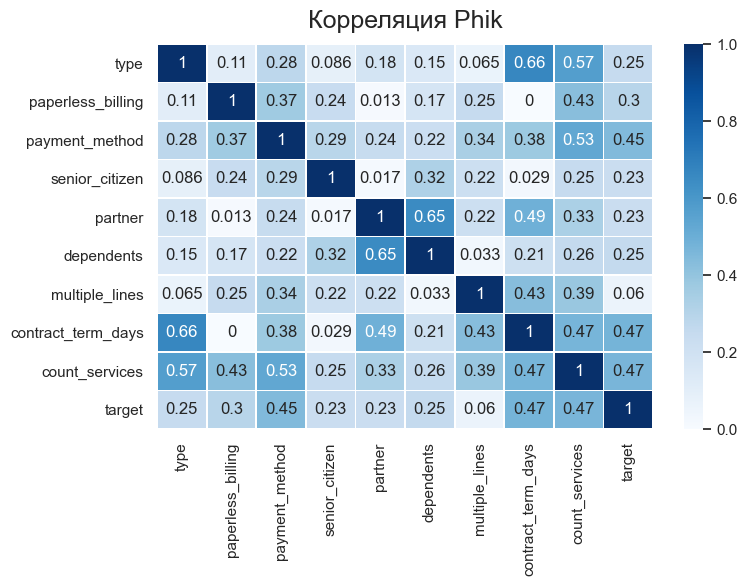

**Итоговый перечень признаков для обучения моделей:**

|Признак | Тип признака| 
| --------- | -------- | 
|type| исходный, категориальный   | 
|paperless_billing| исходный, категориальный |       
|payment_method | исходный, категориальный   |      
|senior_citizen|  исходный, категориальный  |   
|partner | исходный, категориальный  |     
|dependents  |  исходный, категориальный   | 
|multiple_lines|исходный, категориальный |
|contract_term_days|синтетический, количественный  |
|count_services|синтетический, количественный |
|target|целевой, бинарный|

В рамках **подготовки признаков для построения модели** создадим отдельные `трансформеры для логистической регрессии и случайного леса`:
- для регрессии будем использовать как кодирование категориальных признаков (`OneHotEncoder`), так и шкалирование (`StandardScaler`) для количественных признаков;
- для случайного леса шкалирование не требуется, применим только `OneHotEncoder`.

Наименования категориальных признаков использовались для catboost, для lightgbm указание признаков и кодировка не потребовались - необходимые признаки заранее приведены к типу category.

### Методы ML

#### Дополнительные требования к качеству модели от заказчика

На первоначальном этапе были определены следующие требования:
- целевая метрика **ROC-AUC** должна составить **не менее 0.85** на тестовой выборке;
- размер тестовой выборки равен 0.25;
- модель должна наиболее полно (**приоритетна метрика recall**) определять целевой класс (ушедших клиентов), так как маркетологи посчитали, что удержание текущих клиентов дешевле, чем возврат ушедших клиентов.

Данные условия были учтены при построении и оценке качества моделей.

#### Выбор методов машинного обучения и способа подбора гиперпараметров

Для достижения требуемого качества были выбраны различные **алгоритмы машинного обучения** для прогнозирования целевого класса:

|Методы ML| Основные характеристики|
| --------- | -------- | 
|Градиентные бустинги (CatBoostClassifier и LGBMClassifier)| простота реализации и хорошая обобщающая способность. В реальных задачах удается строить композиции, превосходящие по качеству базовые алгоритмы.|
|RandomForestClassifier |гибкость и высокая точность; практически не чувствителен к выбросам в данных из-за случайного семплирования (random sample); не чувствителен к масштабированию и к другим монотонным преобразованиям значений признаков. |
| LogisticRegression| простой и эффективный алгоритм, не требующий большого количества вычислительных ресурсов; не требует практически никакой настройки параметров, выводит хорошо откалиброванные предсказанные вероятности; благодаря простоте и быстроте может использоваться как базовая модель для измерения производительности более сложных алгоритмов.|


Нейронные сети не использовали, так как малое количество объектов наблюдения не позволит достичь необходимого качества модели.

Для поиска оптимальных гиперпараметров будем использовать библиотеку `Optuna`, которая является альтернативой GridSearchCV.

В завершении будет выбрана модель с наилучшими показателями целевой метрики ROC-AUC.

#### Предподготовка данных для различных моделей

- `CatBoostClassifier`

Для модели CatBoostClassifier не выполнялась предподготовка данных, только указали категориальные признаки, так как модель сама умеет их кодировать.

-  `LGBMClassifier`

Для обучения модели LGBMClassifier не требовалось даже указания категориальных признаков - модель самостоятельно находит и кодирует признаки.

- `RandomForestClassifier`

Для случайного леса с помощью трансформера применили только OneHotEncoder, так как шкалирование для данной модели не требуется - она не чувствительна к необработанным количественным переменным. 

- `LogisticRegression`

Для логистической регрессии сделали предобработку данных в виде кодирования категориальных признаков (OneHotEncoder) и шкалирование количественных признаков (StandardScaler).

#### Выбор лучшей модели

По результатам подбора гиперпараметров и кросс-валидации получили следующие результаты:

|	|CatBoostClassifier|	LGBMClassifier|	RandomForestClassifier|	LogisticRegression|
|----------|-------------|---------|----------|-----------|
|ROC-AUC	|0.92	|0.90	|0.79	|0.82|
Accuracy|	0.85|	0.76|	0.69|	0.72|
Recall|	0.80|	0.74	|0.79	|0.79|


Лучшее качество модели показал CatBoostClassifier - 0.92 (ROC-AUC), 0.85 (Accuracy) и 0.80 (Recall). 

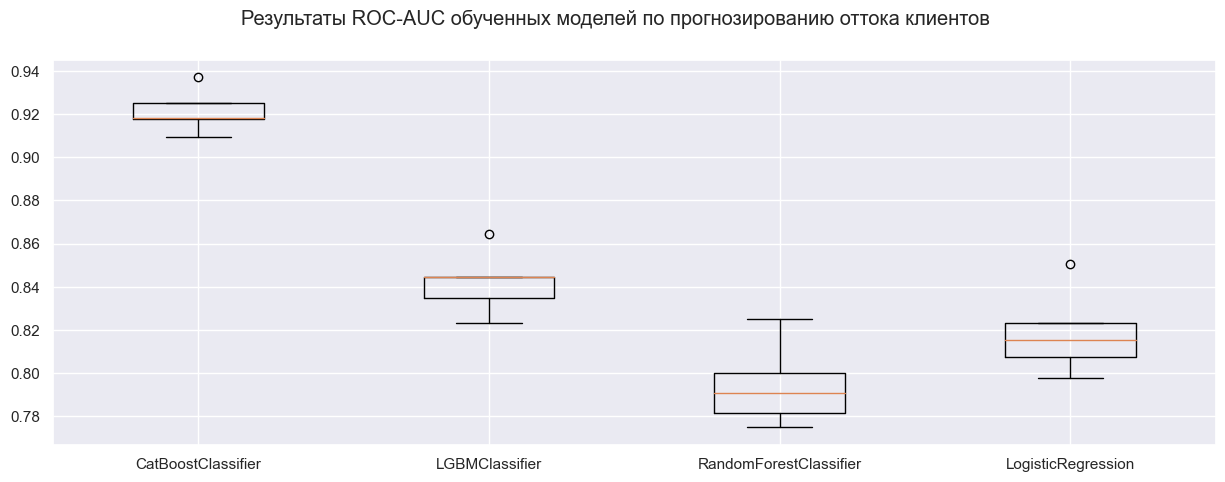

На диаграмме видим, что CatBoost показывает стабильно высокие результаты при кросс-валидации (низкое стандартное отклонение).

CatBoostClassifier признана лучшей моделью (из обученных) и использована для тестирования.

### Результаты

#### Результаты тестирования и метрики качества

По результатам тестирования получены следующие метрики:
- **ROC-AUC составляет 0.93**.

Дополнительные метрики:
- **Accuracy = 0.86**
- **Recall = 0.84**

Полученная модель соответствует требованиям по целевой метрике ROC-AUC - не менее 0.85 на тестовой выборке.

Визуализировав ROC кривую, получили следующий график:

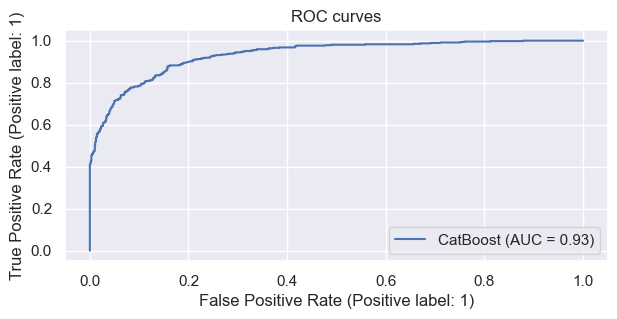

Для лучшей интерпретации полученных результатов была построена **матрица ошибок:**

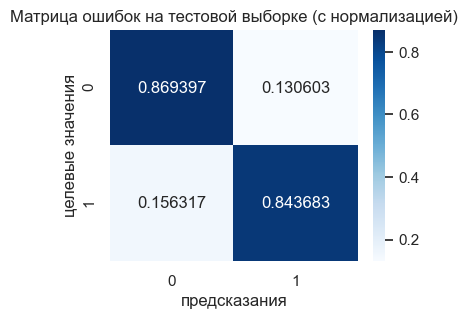

При оценке матрицы ошибок был выявлен перевес метрики Recall в пользу 0 класса. Так как по данным маркетологов удержание текущих клиентов дешевле, чем возврат ушедших клиентов, то необходимо повысить значение Recall и минимизировать ложноотрицательные ошибки (клиенты были классифицированы как лояльные, но фактически уйдут из компании).

Для этого подобрали новое пороговое значение. Визуализировали измение порога присвоения класса и подобрали оптимальный порог с учетом метрики Accuracy и Recall.

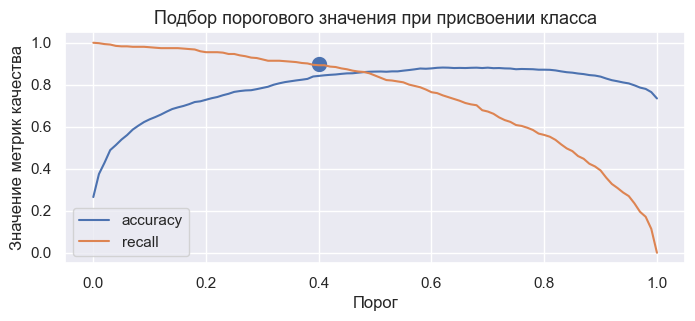

Подобрали такой порог, чтобы Accuracy не значительно снизилась, а Recall максимально увеличилась - получим 0.4. Применив новый порог, получили новую матрицу ошибок:

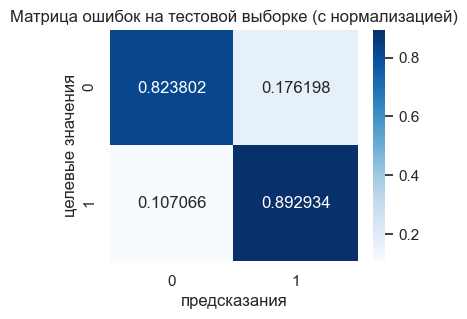

Ошибку в определении 1 класса снизили на 0.05, соответственно повысили Recall до 0.89. Полнота (Recall) 1-го класса уменьшилась на 0.05 и стала равняться 0.82. 

Таким образом, порог определения класса скорректирован в соответстствие с поставленными бизнес-целями.

#### Оценка важности признаков

Оценили график важности признаков с помощью библиотеки SHAP:

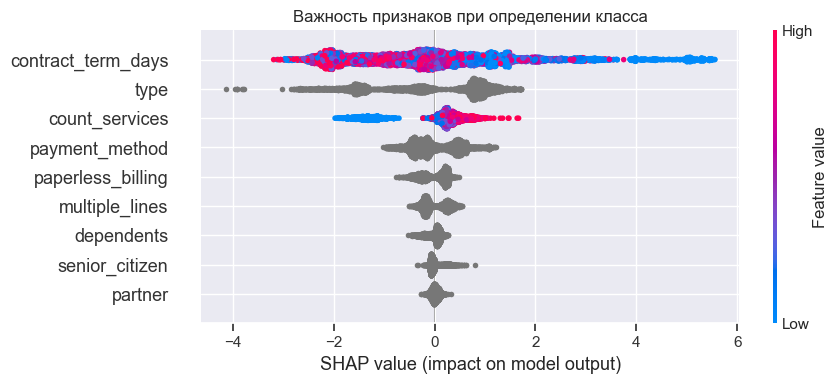

В завершении анализа итоговой модели провели оценку ТОП-3 признаков, влияющих на предсказание модели:
1. **Срок сотрудничества**. Самым весомым признаком является срок сотрудничества - чем больше срок сотрудничества, тем ниже вероятность ухода клиента. И наоборот - бывшие клиенты, в большинстве своем, сотрудничали с оператором короткое время (ранее мы выяснили, что примерный срок сотрудничества составлял 30-60 дней).
2. **Тип договора по сроку**. У лояльных клиентов срок договора более длительный.
3. **Количество услуг**. Мало склонны к уходу клиенты с минимальным количеством услуг - ранее мы выяснили, что это клиенты, использующие только телефонную связь. Тем не менее, при максимальном количестве услуг у клиентам, вероятность, что он уйдет ниже.

### Заключение
<a id='conclusion'></a>

**Оценка выполнения плана работ проекта:**

В ходе выполнения проекта были выполнены все поставленные задачи. Изменения, в части реализации плана, были внесены в следующие пункты:
- срок сотрудничества с клиентом рассчитан в днях, а не в месяцах, как было запланировано. Данная корректировка внесена для более точного расчета признака;
- не были рассчитаны средние ежемесячные затраты на клиента, так как в ходе уточнения дополнительной информации от руководителя (тимлида) были получены уточнения, что такой показатель уже находится в датасете с договорами;
- было построено 4 модели, а не 5, так как среди построенных моделей выявился явный лидер по метрикам качества (CatBoost) и время, запланированное на построение 5 модели, было потрачено на оптимизацию модели-лидера;
- для подбора гиперпараметров был использован не GridSearchCV, а библиотека Optuna, которая обладает следующими преимуществами:
     - `скорость работы`;
     - удобно формировать сетки параметров;
     - возможность задавать количество 'попыток' для подбора гиперпараметров.

Реализация закрепленных в плане задач, позволила построить модель машинного обучения, соответствующую всем заданным требования качества:
- `достигнута целевая метрика ROC-AUC` более 0.85 (результаты построенной модели на тестовой выборке равны 0.93);
- `учтен фактор более дорогого привлечения клиентов, чем удержания` - был скорректирован порог определения классов в сторону увеличения метрики `Recall` при определении целевого класса (бывших клиентов).

______
**Трудности, возникшие в процессе реализации задач проекта:**
- наблюдался некритичный дисбаланс классов, для корректировки которого была использована, встроенная в параметры моделей, балансировка;
- можно отметить необходимость ручной корректировки порога присвоения класса. Модель, показавшая наилучшую метрику качества ROC-AUC, не соответствовала ожидаемому уровню метрики Recall, поэтому была потребность в понижении порога определения 1-го класса, чтобы повысить долю выявления нелояльных клиентов с целью их удержания.

В целом при реализации проекта не возникло существенных трудностей:
- данные не содержали пропусков неизвестной природы, аномалий и дубликатов; 
- цель и основные задачи проекта были ясны.
______

**Ключевые шаги в решении задачи:**

Для решения поставленной задачи можно выделить следующие ключевые шаги (этапы):
1. Загрузка и подготовка данных к анализу;
2. Разведочный анализ данных;
3. Выбор и предподготовка признаков для обучения моделей;
4. Определение целевых метрик качества согласно типу задачи и потребностям бизнеса;
5. Подбор гиперпараметров, построение и обучение моделей;
6. Финальное тестирование и формирование выводов по итогам проекта.

______
**Перечень признаков и их предобработка для обучения модели:**

Для обучения модели были использованы следующие **признаки:**
- `исходные, категориальные`: type, paperless_billing, payment_method, senior_citizen, partner, dependents, multiple_lines;
- `синтетические, количественные`: contract_term_days (срок сотрудничества в днях), count_services (кол-во услуг клиента);
- `целевой, бинарный`: target.

Использованные **способы предобработки признаков:**
- для `catboost` передавался список категориальных признаков без дополнительной предобработки самих признаков;
- в `lightgbm` признаки передавались без дополнительной предобработки (категориальные признаки были изначально приведены к типу category), так как модель самостоятельно распознает типы признаков и кодирует их для обучения. 
- для части моделей были созданы **отдельные трансформеры**:
    - для `регрессии` использовали как кодирование категориальных признаков (`OneHotEncoder`), так и шкалирование (`StandardScaler`) для количественных признаков;
    - для `случайного леса` шкалирование не требуется, применили только `OneHotEncoder`.


______
**Итоговые параметры модели и ее качество:**

`CatBoostClassifier(random_state=RANDOM_STATE, class_weights=[1, 2.7], 
                    custom_metric= 'AUC', cat_features=ohe_features, 
                    logging_level='Silent', learning_rate=0.04936813609097174, 
                    iterations=923)`

По результатам тестирования получены следующие метрики качества:
- **ROC-AUC составляет 0.93**.
- **Accuracy = 0.86**
- **Recall = 0.84**

### Планы по дальнейшей работе над проектом

**В ходе дальнейшей работы над проектов стоит реализовать следующие задачи:**

- `кластеризация`, чтобы разделить клиентов не только на действующих и бывших, но и провести сегментацию внутри этих групп. Это позволит еще глубже изучить `поведенческие особенности клиентских кластеров` и разработать для них более `персонифицированные предложения` для удержания.
- `анализ бюджета маркетинга`. Запросить у маркетологов бюджет на удержание одного клиента и плановый бюджет на месяц/год. Это позволит `настроить пороговое значение модели` более точно - сократить либо увеличить количество выявленных нелояльных клиентов. Либо увеличить точность (`precision`), то есть находить только тех клиентов, которые с большей вероятностью уйдут либо увеличить полноту (`recall`), чтобы выявить как можно больше нелояльных клиентов, если бюджет будет достаточным.